In [2]:
#Install Dependencies 
# !pip install torch torchvision timm scikit-learn matplotlib seaborn ipywidgets

# pip install ipywidgets

In [3]:
#Install Dependencies 
# !pip install torch torchvision timm scikit-learn matplotlib seaborn ipywidgets

# Import Libraries
# --------------------------

import os
import io
import torch
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm import create_model
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import ipywidgets as widgets
from IPython.display import display


In [4]:
# Checking input folders to find dataset path 

print(" Available input folders:")
print(os.listdir("/kaggle/input"))


 Available input folders:
['alzheimer-vit-checkpoints', 'working-dataset', 'oasis-demographic-dataset', 'oasisdataset']


In [5]:
#identifying and cheking the classes ex: 4 classes 

original_dir = '/kaggle/input/oasisdataset'
print("Classes found:", os.listdir(original_dir))


Classes found: ['Non Demented', 'Very mild Dementia', 'Moderate Dementia', 'Mild Dementia']


In [ ]:
# already spit using downloaded files from now on 

# Split original dataset into train/val/test folders


# Correct dataset path
original_dir = '/kaggle/input/oasisdataset'
output_dir = '/kaggle/working/data_split'
split_ratio = [0.7, 0.15, 0.15]  # 70% train, 15% val, 15% test

# Reset any old split folders
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

# Create split folders
for split in ['train', 'val', 'test']:
    for cls in os.listdir(original_dir):
        cls_path = os.path.join(original_dir, cls)
        if os.path.isdir(cls_path):
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

# Split images per class
for cls in os.listdir(original_dir):
    class_path = os.path.join(original_dir, cls)
    if not os.path.isdir(class_path): continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if len(images) == 0:
        print(f" No images found in: {cls}")
        continue

    random.shuffle(images)
    train_idx = int(len(images) * split_ratio[0])
    val_idx = int(len(images) * (split_ratio[0] + split_ratio[1]))

    for i, img_file in enumerate(images):
        src = os.path.join(class_path, img_file)
        if i < train_idx:
            dst = os.path.join(output_dir, 'train', cls, img_file)
        elif i < val_idx:
            dst = os.path.join(output_dir, 'val', cls, img_file)
        else:
            dst = os.path.join(output_dir, 'test', cls, img_file)
        shutil.copy2(src, dst)

print(" Dataset successfully split into train / val / test folders.")



#running only once if already split  - already spit using downloaded files from now on 


In [ ]:
for split in ['train', 'val', 'test']:
    path = f"/kaggle/working/data_split/{split}"
    print(f"\n {split.upper()} class counts:")
    for cls in os.listdir(path):
        n = len(os.listdir(os.path.join(path, cls)))
        print(f"  {cls}: {n} images")


In [6]:
sample_class = '/kaggle/input/working-dataset/data_split/train/Moderate Dementia'
print("Files found:", os.listdir(sample_class)[:5])  # show 5 files

Files found: ['OAS1_0351_MR1_mpr-1_151.jpg', 'OAS1_0308_MR1_mpr-4_100.jpg', 'OAS1_0308_MR1_mpr-4_146.jpg', 'OAS1_0308_MR1_mpr-1_127.jpg', 'OAS1_0308_MR1_mpr-4_116.jpg']


In [7]:
# Configurations

train_dir = '/kaggle/input/working-dataset/data_split/train'
val_dir = '/kaggle/input/working-dataset/data_split/val'
test_dir = '/kaggle/input/working-dataset/data_split/test'

# ----------------- Configuration -----------------
img_size = 224
batch_size = 16
epochs = 50
learning_rate = 1e-4
weight_decay = 1e-5
model_name = 'vit_base_patch16_224'
use_scheduler = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on:", device)


Running on: cuda


In [8]:
# Data Transforms and Loaders

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class_names = train_data.classes
print("Classes:", class_names)

Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


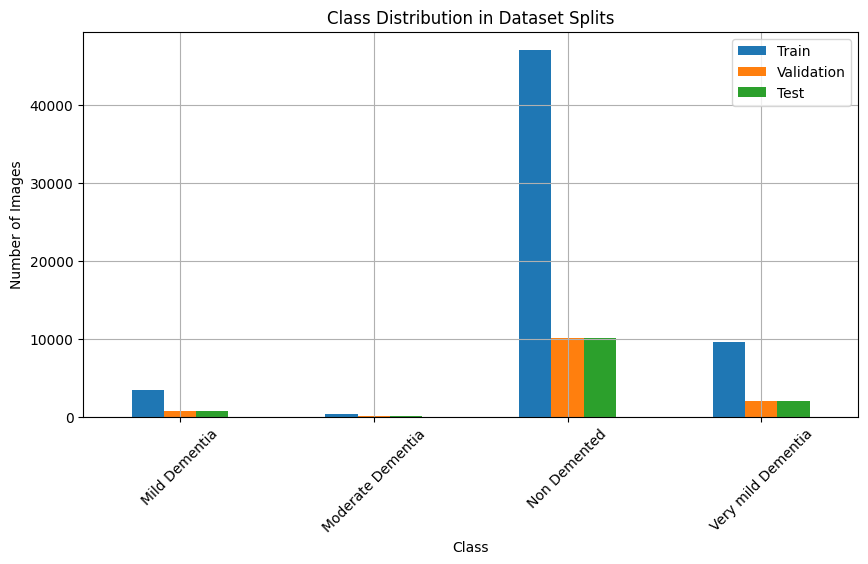

In [9]:
# Dataset Class Distribution


train_class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names}
val_class_counts = {cls: len(os.listdir(os.path.join(val_dir, cls))) for cls in class_names}
test_class_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in class_names}

df_dist = pd.DataFrame({
    'Class': class_names,
    'Train': [train_class_counts[cls] for cls in class_names],
    'Validation': [val_class_counts[cls] for cls in class_names],
    'Test': [test_class_counts[cls] for cls in class_names]
})

df_dist.set_index('Class').plot(kind='bar', figsize=(10, 5))
plt.title('Class Distribution in Dataset Splits')
plt.ylabel('Number of Images')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


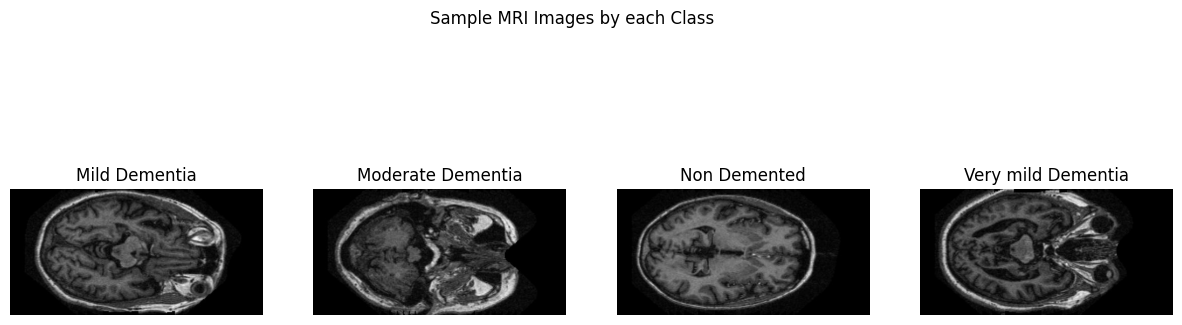

In [10]:
# Show Sample Images per Class

def show_random_images(dataset_path, class_names):
    fig, axs = plt.subplots(1, len(class_names), figsize=(15, 5))
    for i, cls in enumerate(class_names):
        class_folder = os.path.join(dataset_path, cls)
        img_name = random.choice(os.listdir(class_folder))
        img_path = os.path.join(class_folder, img_name)
        img = Image.open(img_path)
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(cls)
        axs[i].axis('off')
    plt.suptitle('Sample MRI Images by each Class')
    plt.show()

show_random_images(train_dir, class_names)


In [ ]:
from kaggle_secrets import UserSecretsClient
from IPython.display import FileLink

# Upload manually via the file button in the notebook (left panel > "Upload")


In [ ]:
# testing done using downloased check points now
"""
Clean ViT Training (Fresh Start, No Resume) — OASIS-1 MRI  (No-lag hardened)
----------------------------------------------------------------------------

Stable-by-default settings for Kaggle:
- workers=0, pin_memory=False
- small batch (8), mixed precision (AMP) + TF32 enabled on CUDA
- safe image loader with per-file timeout (skips hangy/corrupt files)
- batch-time watchdog (skips any batch that stalls)
- light augmentations
- WeightedRandomSampler for class imbalance
- Early stopping + LR scheduler
- Heartbeat logs so tqdm never "looks frozen"
- Soft epoch time cap to avoid endless epochs on bad data

Outputs:
- best_by_loss.pt, best_by_f1.pt
- metrics_epoch_{k}.json (val summary per epoch)
- loss_curve.png, acc_f1_curve.png
"""

import os, time, json, random, warnings, gc, signal
from typing import Dict, Any, List
import numpy as np
import matplotlib
matplotlib.use("Agg")  # offscreen backend
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch import amp
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from timm import create_model
from tqdm import tqdm
from PIL import Image, ImageFile
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_fscore_support, balanced_accuracy_score
)

# -------------------------
# Paths (edit if needed)
# -------------------------
TRAIN_DIR = "/kaggle/working/data_split/train"
VAL_DIR   = "/kaggle/working/data_split/val"
TEST_DIR  = "/kaggle/working/data_split/test"

# -------------------------
# Config (stable defaults)
# -------------------------
MODEL_NAME   = "vit_base_patch16_224"
IMG_SIZE     = 224
BATCH_SIZE   = 8          # conservative
EPOCHS       = 30
LR           = 1e-4
WEIGHT_DECAY = 1e-5
PATIENCE     = 7

# DataLoader: zero workers is slow but extremely reliable on Kaggle
NUM_WORKERS  = 0
PIN_MEMORY   = False
TIMEOUT_SEC  = 0

# Light augs (reduce CPU/GPU spikes)
ALLOW_HFLIP  = False
ROT_DEG      = 8

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

CKPT_BEST_LOSS = "best_by_loss.pt"
CKPT_BEST_F1   = "best_by_f1.pt"
CURVE_LOSS     = "loss_curve.png"
CURVE_ACC_F1   = "acc_f1_curve.png"

# Watchdogs
FILE_DECODE_TIMEOUT_S = 2       # per-file decode budget
MAX_BATCH_SECONDS     = 10      # per-batch budget (train/val)
MAX_EPOCH_MIN         = 45      # soft cap to avoid forever-epochs

# -------------------------
# Reproducibility + stability
# -------------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
warnings.filterwarnings("once")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Enable TF32 for safe speedup on Ampere+ (has no measurable accuracy downside for ViT finetune)
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision("high")

def free_mem():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# -------------------------
# Robust loader with per-file timeout
# -------------------------
class _ImageTimeout(Exception): pass
def _alarm_handler(signum, frame): 
    raise _ImageTimeout()

signal.signal(signal.SIGALRM, _alarm_handler)

def safe_loader(path: str) -> Image.Image:
    """PIL sometimes hangs on decode; this enforces a hard timeout and returns a gray tile if needed."""
    for _ in range(3):
        try:
            signal.alarm(FILE_DECODE_TIMEOUT_S)
            with Image.open(path) as img:
                img.load()              # force decode while alarm is active
                img = img.convert("L")  # single-channel base; we’ll expand to 3ch in transforms
            signal.alarm(0)
            return img
        except _ImageTimeout:
            # retry; if it keeps timing out, fall back to gray
            continue
        except Exception:
            continue
        finally:
            signal.alarm(0)
    return Image.new("L", (IMG_SIZE, IMG_SIZE), 128)

# -------------------------
# Transforms
# -------------------------
train_tfms = [
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(ROT_DEG),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
]
if ALLOW_HFLIP:
    train_tfms.insert(3, transforms.RandomHorizontalFlip(p=0.5))
transform_train = transforms.Compose(train_tfms)

transform_eval = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# -------------------------
# Datasets
# -------------------------
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=transform_train, loader=safe_loader)
val_ds   = datasets.ImageFolder(VAL_DIR,   transform=transform_eval,  loader=safe_loader)
test_ds  = datasets.ImageFolder(TEST_DIR,  transform=transform_eval,  loader=safe_loader)

class_names = train_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)

def describe_split(name: str, ds: datasets.ImageFolder) -> Dict[str, int]:
    counts = np.zeros(len(ds.classes), dtype=int)
    for _, label in ds.samples:
        counts[label] += 1
    summary = {cls: int(counts[idx]) for cls, idx in ds.class_to_idx.items()}
    print(f"\n{name} class distribution:")
    for cls in ds.classes:
        print(f"  {cls}: {summary[cls]}")
    return summary

describe_split("Train", train_ds)
describe_split("Val",   val_ds)
describe_split("Test",  test_ds)

# -------------------------
# Sampler for imbalance
# -------------------------
labels = [lbl for _, lbl in train_ds.samples]
counts = np.bincount(labels, minlength=num_classes)
class_w = 1.0 / np.maximum(counts, 1)
class_w = class_w / class_w.sum() * num_classes
sample_weights = torch.tensor([class_w[l] for l in labels], dtype=torch.float)
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
print("\nWeightedRandomSampler configured.")
print("Class counts:", counts)
print("Class sampling weights (normalized):", class_w)

# -------------------------
# DataLoaders
# -------------------------
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, timeout=TIMEOUT_SEC)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, timeout=TIMEOUT_SEC)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, timeout=TIMEOUT_SEC)

# -------------------------
# Model / Loss / Optimizer / Scheduler / AMP
# -------------------------
model = create_model(MODEL_NAME, pretrained=True, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)   # no class weights with sampler
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3, factor=0.5, verbose=True)
scaler = amp.GradScaler("cuda", enabled=(device.type == "cuda"))

# -------------------------
# Train
# -------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_macro_f1s, val_bal_accs = [], []

best_val_loss = float("inf")
best_f1 = -1.0
early_stop = 0

def compact_class_report(y_true, y_pred) -> Dict[str, Dict[str, float]]:
    rep = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
    out = {}
    for cls in class_names:
        s = rep.get(cls, {})
        out[cls] = dict(P=round(s.get("precision", 0.0), 3),
                        R=round(s.get("recall", 0.0), 3),
                        F1=round(s.get("f1-score", 0.0), 3),
                        N=int(s.get("support", 0)))
    return out

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    skipped_batches = 0
    steps = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]", mininterval=0.5, smoothing=0.1)
    for imgs, labels in pbar:
        steps += 1
        t_batch = time.time()
        try:
            imgs, labels = imgs.to(device), labels.to(device)
            with amp.autocast("cuda", enabled=(device.type=="cuda")):
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

            running_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Hard batch watchdog
            if time.time() - t_batch > MAX_BATCH_SECONDS:
                skipped_batches += 1
                continue

            if steps % 200 == 0:
                pbar.write(f"…heartbeat: {total} samples, lr={optimizer.param_groups[0]['lr']:.2e}")

            pbar.set_postfix(loss=loss.item(), acc=(correct/total if total else 0.0),
                             lr=optimizer.param_groups[0]["lr"])
        except Exception as e:
            skipped_batches += 1
            pbar.write(f"[WARN] Skipped batch due to error: {type(e).__name__}")
            continue

        # Soft epoch time cap
        if (time.time() - t0) / 60.0 > MAX_EPOCH_MIN:
            pbar.write(f"[INFO] Epoch taking > {MAX_EPOCH_MIN} min — breaking early to save progress.")
            break

    train_loss = running_loss / max(1, steps)
    train_acc  = correct / max(1, total)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # -------------------------
    # Validate (with watchdog)
    # -------------------------
    model.eval()
    val_running, v_correct, v_total = 0.0, 0, 0
    y_true_val, y_pred_val = [], []
    v_steps = 0
    with torch.no_grad():
        pval = tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [Val]", mininterval=0.5, smoothing=0.1)
        for imgs, labels in pval:
            v_steps += 1
            t_batch = time.time()
            try:
                imgs, labels = imgs.to(device), labels.to(device)
                with amp.autocast("cuda", enabled=(device.type=="cuda")):
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)
                val_running += loss.item()
                preds = outputs.argmax(1)
                v_correct += (preds == labels).sum().item()
                v_total += labels.size(0)
                y_true_val.extend(labels.cpu().numpy().tolist())
                y_pred_val.extend(preds.cpu().numpy().tolist())

                # Batch watchdog for val
                if time.time() - t_batch > MAX_BATCH_SECONDS:
                    pval.write("[WARN] Skipped slow val batch")
                    continue

                if v_steps % 200 == 0:
                    pval.write(f"…val heartbeat: {v_total} samples")
            except Exception as e:
                pval.write(f"[WARN] Skipped val batch due to error: {type(e).__name__}")
                continue

    val_loss = val_running / max(1, v_steps)
    val_acc  = v_correct / max(1, v_total) if v_total else 0.0
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true_val, y_pred_val, average="macro", zero_division=0
    )
    bal_acc = balanced_accuracy_score(y_true_val, y_pred_val) if v_total else 0.0

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_macro_f1s.append(f1)
    val_bal_accs.append(bal_acc)

    scheduler.step(val_loss)

    # Save epoch metrics snapshot
    with open(f"metrics_epoch_{epoch}.json", "w") as f:
        json.dump({
            "epoch": epoch,
            "train": {"loss": train_loss, "acc": train_acc, "skipped_batches": skipped_batches},
            "val":   {"loss": val_loss, "acc": val_acc, "macro_f1": f1, "balanced_acc": bal_acc},
            "class_report": compact_class_report(np.array(y_true_val), np.array(y_pred_val)) if v_total else {},
            "lr": optimizer.param_groups[0]["lr"],
        }, f, indent=2)

    # Checkpoints (weights only, fresh start paradigm)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), CKPT_BEST_LOSS)
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), CKPT_BEST_F1)

    dt = (time.time() - t0) / 60.0
    print(
        f"Epoch {epoch:02d} in {dt:.2f} min | "
        f"Train L {train_loss:.4f} A {train_acc:.4f} (skipped {skipped_batches}) | "
        f"Val L {val_loss:.4f} A {val_acc:.4f} | "
        f"Macro-F1 {f1:.4f} BalancedAcc {bal_acc:.4f}"
    )

    # Early stopping
    if val_loss > best_val_loss + 1e-8:
        early_stop += 1
    else:
        early_stop = 0
    print(f"Patience {early_stop}/{PATIENCE}")
    if early_stop >= PATIENCE:
        print(f"Early stopping at epoch {epoch}")
        break

    # Free memory between epochs
    free_mem()

# -------------------------
# Final plots
# -------------------------
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(12,4))
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses,   label="Val Loss")
plt.title("Loss over Epochs"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout(); plt.savefig(CURVE_LOSS, dpi=200); print(f"Saved {CURVE_LOSS}")

plt.figure(figsize=(12,4))
plt.plot(epochs_range, train_accs,     label="Train Acc")
plt.plot(epochs_range, val_accs,       label="Val Acc")
plt.plot(epochs_range, val_macro_f1s,  label="Val Macro-F1")
plt.plot(epochs_range, val_bal_accs,   label="Val Balanced Acc")
plt.title("Accuracy / Macro-F1 / Balanced Acc"); plt.xlabel("Epoch"); plt.ylabel("Score"); plt.legend()
plt.tight_layout(); plt.savefig(CURVE_ACC_F1, dpi=200); print(f"Saved {CURVE_ACC_F1}")

# -------------------------
# Quick test evaluation (optional)
# -------------------------
@torch.no_grad()
def eval_split(loader: DataLoader, name: str):
    model.eval()
    y_true, y_pred = [], []
    steps = 0
    for imgs, labels in loader:
        steps += 1
        t_batch = time.time()
        try:
            imgs, labels = imgs.to(device), labels.to(device)
            with amp.autocast("cuda", enabled=(device.type=="cuda")):
                logits = model(imgs)
            preds = logits.argmax(1)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
            if time.time() - t_batch > MAX_BATCH_SECONDS:
                print("[WARN] Skipped slow test batch")
                continue
        except Exception as e:
            print(f"[WARN] Skipped test batch due to error: {type(e).__name__}")
            continue
    if len(y_true) and len(y_pred):
        rep = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
        cm = confusion_matrix(y_true, y_pred)
        print(f"\n{name} classification report:\n{rep}")
        print(f"{name} confusion matrix:\n{cm}")
    else:
        print(f"[INFO] No {name} metrics (all batches skipped?)")

# Load best-by-loss weights and check TEST
state = torch.load(CKPT_BEST_LOSS, map_location=device)
model.load_state_dict(state)
eval_split(test_loader, "TEST")


In [ ]:
import os, time, torch, glob, json
print("PING @", time.strftime("%H:%M:%S"))
print("CUDA:", torch.cuda.is_available())
print("Files:", [os.path.basename(p) for p in glob.glob("/kaggle/working/*.pt")])

In [ ]:
# Define extract_features function
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in tqdm(dataloader, desc="Extracting Features"):
            imgs = imgs.to(device)
            out = model.forward_features(imgs)[:, 0]  # CLS token
            features.append(out.cpu())
            labels.append(lbls)

    features = torch.cat(features).numpy()
    labels = torch.cat(labels).numpy()
    return features, labels


In [ ]:
import pandas as pd
import numpy as np

features, labels = extract_features(model, train_loader)

df = pd.DataFrame(features)
df['label'] = labels
df.to_csv('/kaggle/working/mri_embeddings_testing.csv', index=False)

print(" Feature embeddings saved to mri_embeddings_testing.csv")


In [ ]:
!pip install -q torchcam

In [ ]:
from torchcam.utils import overlay_mask
from torchcam.methods import SmoothGradCAMpp

In [ ]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import matplotlib.pyplot as plt
import torch

In [ ]:
# Load 1 sample image from test set
img_path, label = test_data.samples[0]
img = Image.open(img_path).convert("RGB")

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize([0.5], [0.5])
])

input_tensor = transform(img).unsqueeze(0).to(device)
input_tensor.requires_grad = True  #  Required for CAM


In [ ]:
model.eval()  #Required
cam_extractor = SmoothGradCAMpp(model, target_layer="blocks.11.norm1")  # Best for ViT-base


In [ ]:
output = model(input_tensor)
predicted_class = output.argmax().item()

# Generate Grad-CAM for predicted class
activation_map = cam_extractor(predicted_class, output)

# Overlay heatmap
result = overlay_mask(
    to_pil_image(input_tensor.squeeze().cpu()),
    to_pil_image(activation_map[0].cpu(), mode='F'),
    alpha=0.5
)

plt.imshow(result)
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis('off')
plt.show()


In [ ]:
import numpy as np
import cv2

# Convert activation map to numpy
cam_img = activation_map[0].cpu().numpy()

# Normalize 0–255
cam_img = (cam_img - cam_img.min()) / (cam_img.max() - cam_img.min())
cam_img = np.uint8(cam_img * 255)

# Threshold
_, thresh = cv2.threshold(cam_img, 180, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Load original image as BGR
original = np.array(to_pil_image(input_tensor.squeeze().cpu()).convert("RGB"))
original = cv2.cvtColor(original, cv2.COLOR_RGB2BGR)

# Draw bounding boxes
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(original, (x, y), (x + w, y + h), (0, 0, 255), 2)

# Convert back to RGB for matplotlib
highlighted = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

plt.imshow(highlighted)
plt.title(f"Highlighted ROI: {class_names[predicted_class]}")
plt.axis("off")
plt.show()

confidence = torch.softmax(output, dim=1)[0][predicted_class].item()
print(f"Prediction: {class_names[predicted_class]} ({confidence:.2f} confidence)")



Test classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


<ipython-input-11-549b11b363b5>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(CKPT_PATH, map_location=device)


Loaded checkpoint: /kaggle/input/alzheimer-vit-checkpoints/best_by_f1.pt

Test Classification Report:
                     precision    recall  f1-score   support

     Mild Dementia       0.90      0.98      0.94       751
 Moderate Dementia       1.00      1.00      1.00        74
      Non Demented       0.99      0.97      0.98     10084
Very mild Dementia       0.91      0.97      0.94      2059

          accuracy                           0.97     12968
         macro avg       0.95      0.98      0.97     12968
      weighted avg       0.98      0.97      0.97     12968

Balanced Accuracy: 0.9821048719976948
Confusion Matrix:
 [[ 738    0   13    0]
 [   0   74    0    0]
 [  77    0 9811  196]
 [   6    0   50 2003]]
Saved: test_eval.json, confusion_matrix_test.png


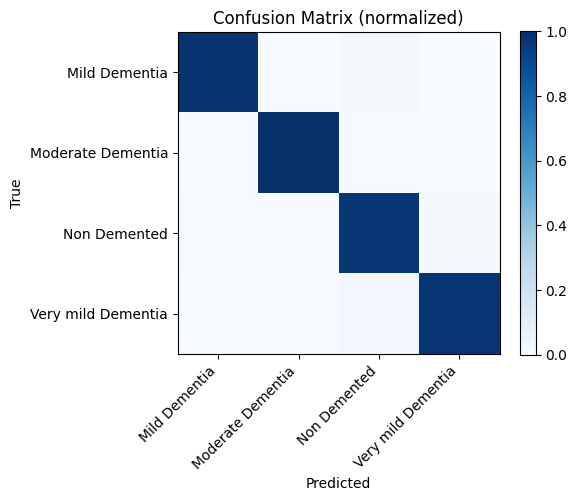

In [11]:
import torch
from timm import create_model
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import json

# -------------------------
# Config
# -------------------------
MODEL_NAME   = "vit_base_patch16_224"
IMG_SIZE     = 224
BATCH_SIZE   = 64
NUM_CLASSES  = 4   # ['Mild Dementia','Moderate Dementia','Non Demented','Very mild Dementia']

# replace with your dataset name on Kaggle
CKPT_PATH = "/kaggle/input/alzheimer-vit-checkpoints/best_by_f1.pt"  

# Point to your freshly resplit test folder
TEST_DIR   = "/kaggle/input/working-dataset/data_split/test"

IMAGENET_MEAN=[0.485,0.456,0.406]
IMAGENET_STD =[0.229,0.224,0.225]

# -------------------------
# Data
# -------------------------
transform_eval = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_ds = datasets.ImageFolder(TEST_DIR, transform=transform_eval)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
print("Test classes:", test_ds.classes)

# -------------------------
# Model
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(MODEL_NAME, pretrained=False, num_classes=len(test_ds.classes)).to(device)
state = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state)
model.eval()
print("Loaded checkpoint:", CKPT_PATH)

# -------------------------
# Evaluate
# -------------------------
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        logits = model(imgs)
        preds = logits.argmax(1)
        y_true.extend(lbls.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
rep = classification_report(y_true, y_pred, target_names=test_ds.classes, zero_division=0)
bal_acc = balanced_accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print("\nTest Classification Report:\n", rep)
print("Balanced Accuracy:", bal_acc)
print("Confusion Matrix:\n", cm)

# Save results
with open("test_eval.json","w") as f:
    json.dump({"report":rep,"balanced_acc":bal_acc,"confusion_matrix":cm.tolist()}, f, indent=2)

# Plot confusion matrix
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)
plt.figure(figsize=(6,5))
plt.imshow(cm_norm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix (normalized)")
plt.colorbar()
tick_marks = np.arange(len(test_ds.classes))
plt.xticks(tick_marks, test_ds.classes, rotation=45, ha="right")
plt.yticks(tick_marks, test_ds.classes)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix_test.png", dpi=200)
print("Saved: test_eval.json, confusion_matrix_test.png")


In [12]:
# ====== Grad-CAM for ViT-B/16 @224 on OASIS MRI (full cell) ======
!pip -q install grad-cam >/dev/null

import os, json, math, random, warnings
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from timm import create_model

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

warnings.filterwarnings("ignore")

# -------------------------
# Config: paths & params
# -------------------------
MODEL_NAME   = "vit_base_patch16_224"
IMG_SIZE     = 224
BATCH_SIZE   = 32
K_PER_CLASS  = 6         # how many examples per class to visualize
SEED         = 42

# <<< set these to your paths >>>
CKPT_PATH = "/kaggle/input/alzheimer-vit-checkpoints/best_by_f1.pt"
TEST_DIR  = "/kaggle/input/working-dataset/data_split/test"

OUT_DIR   = "/kaggle/working/gradcam_out"
os.makedirs(OUT_DIR, exist_ok=True)

IMAGENET_MEAN=[0.485,0.456,0.406]
IMAGENET_STD =[0.229,0.224,0.225]

# -------------------------
# Repro, device
# -------------------------
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision("high")
print("Device:", device)

# -------------------------
# Data (eval transforms)
# -------------------------
transform_eval = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),   # MRI → 3ch
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_ds = datasets.ImageFolder(TEST_DIR, transform=transform_eval)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
class_names = test_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)

# -------------------------
# Model + weights
# -------------------------
model = create_model(MODEL_NAME, pretrained=False, num_classes=num_classes).to(device)
try:
    state = torch.load(CKPT_PATH, map_location=device, weights_only=True)  # torch>=2.4
except TypeError:
    state = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state)
model.eval()
print("Loaded checkpoint:", CKPT_PATH)

# -------------------------
# ViT reshape transform for CAM (tokens → feature map)
# -------------------------
def vit_reshape_transform(tensor):
    """
    Convert ViT token sequence to spatial feature map for CAM.
    tensor shape: [B, T, C] where T = 1 (CLS) + H*W.
    Output: [B, C, H, W]
    """
    if isinstance(tensor, (list, tuple)):
        tensor = tensor[0]
    assert tensor.dim() == 3, f"Expected [B,T,C], got {tuple(tensor.shape)}"
    B, T, C = tensor.shape
    HW = T - 1
    H = W = int(math.sqrt(HW))
    x = tensor[:, 1:, :]              # drop CLS
    x = x.reshape(B, H, W, C)         # [B, H, W, C]
    x = x.permute(0, 3, 1, 2).contiguous()  # [B, C, H, W]
    return x

# Target layer: last block's pre-attention norm is a good spot for ViT
target_layers = [model.blocks[-1].norm1]

# Choose your CAM variant (GradCAM is fine; GradCAMPlusPlus gives slightly crisper maps)
# cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=vit_reshape_transform)
cam = GradCAMPlusPlus(model=model, target_layers=target_layers, reshape_transform=vit_reshape_transform)
# For very robust/no-gradient variant: EigenCAM
# cam = EigenCAM(model=model, target_layers=target_layers, reshape_transform=vit_reshape_transform)

# -------------------------
# Helpers
# -------------------------
def unnormalize_to_numpy(img_tensor):
    """Convert normalized CHW tensor → HWC float [0,1] RGB for overlay."""
    x = img_tensor.clone().cpu().numpy()
    for c in range(3):
        x[c] = x[c] * IMAGENET_STD[c] + IMAGENET_MEAN[c]
    x = np.clip(x.transpose(1,2,0), 0, 1)
    return x

@torch.no_grad()
def predict_logits(imgs):
    return model(imgs.to(device))

# -------------------------
# Pick K samples per class (deterministic)
# -------------------------
per_class_idx = {i: [] for i in range(num_classes)}
for idx, (_, lbl) in enumerate(test_ds.samples):
    per_class_idx[lbl].append(idx)

picked_indices = []
rng = random.Random(SEED)
for c in range(num_classes):
    rng.shuffle(per_class_idx[c])
    k = min(K_PER_CLASS, len(per_class_idx[c]))
    picked_indices += per_class_idx[c][:k]

print(f"Selected {len(picked_indices)} samples ({K_PER_CLASS} per class if available).")

# -------------------------
# Run CAMs and save overlays
# -------------------------
manifest = []
for idx in tqdm(picked_indices, desc="Grad-CAM"):
    path, true_lbl = test_ds.samples[idx]

    # Load a single image in the same way as dataset (ensures identical preprocessing)
    img_pil = Image.open(path).convert("L").resize((IMG_SIZE, IMG_SIZE))
    img_rgb = Image.merge("RGB", (img_pil, img_pil, img_pil))
    img_t   = transform_eval(img_rgb)             # [3,H,W]
    input_t = img_t.unsqueeze(0).to(device)       # [1,3,H,W]

    logits = predict_logits(input_t)
    pred_lbl = int(torch.argmax(logits, dim=1).item())

    targets = [ClassifierOutputTarget(pred_lbl)]  # or ClassifierOutputTarget(true_lbl)
    grayscale_cam = cam(input_tensor=input_t, targets=targets, eigen_smooth=True)
    grayscale_cam = grayscale_cam[0]  # [H,W], already upsampled to input size

    vis = unnormalize_to_numpy(img_t)             # HWC, [0,1]
    overlay = show_cam_on_image(vis, grayscale_cam, use_rgb=True)

    # Save overlay
    base = os.path.basename(path)
    out_name = f"cam_true-{class_names[true_lbl]}_pred-{class_names[pred_lbl]}_{base.replace('/', '_')}.png"
    out_path = os.path.join(OUT_DIR, out_name)
    Image.fromarray(overlay).save(out_path)

    manifest.append({
        "img_path": path,
        "cam_path": out_path,
        "true": class_names[true_lbl],
        "pred": class_names[pred_lbl],
        "correct": bool(true_lbl == pred_lbl)
    })

# Save manifest for your report script
man_path = os.path.join(OUT_DIR, "gradcam_manifest.json")
with open(man_path, "w") as f:
    json.dump({"classes": class_names, "items": manifest}, f, indent=2)

print(f"\nSaved {len(manifest)} CAM overlays to: {OUT_DIR}")
print(f"Manifest: {man_path}")


Device: cuda
Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
Loaded checkpoint: /kaggle/input/alzheimer-vit-checkpoints/best_by_f1.pt
Selected 24 samples (6 per class if available).


Grad-CAM: 100%|██████████| 24/24 [00:02<00:00, 11.36it/s]


Saved 24 CAM overlays to: /kaggle/working/gradcam_out
Manifest: /kaggle/working/gradcam_out/gradcam_manifest.json


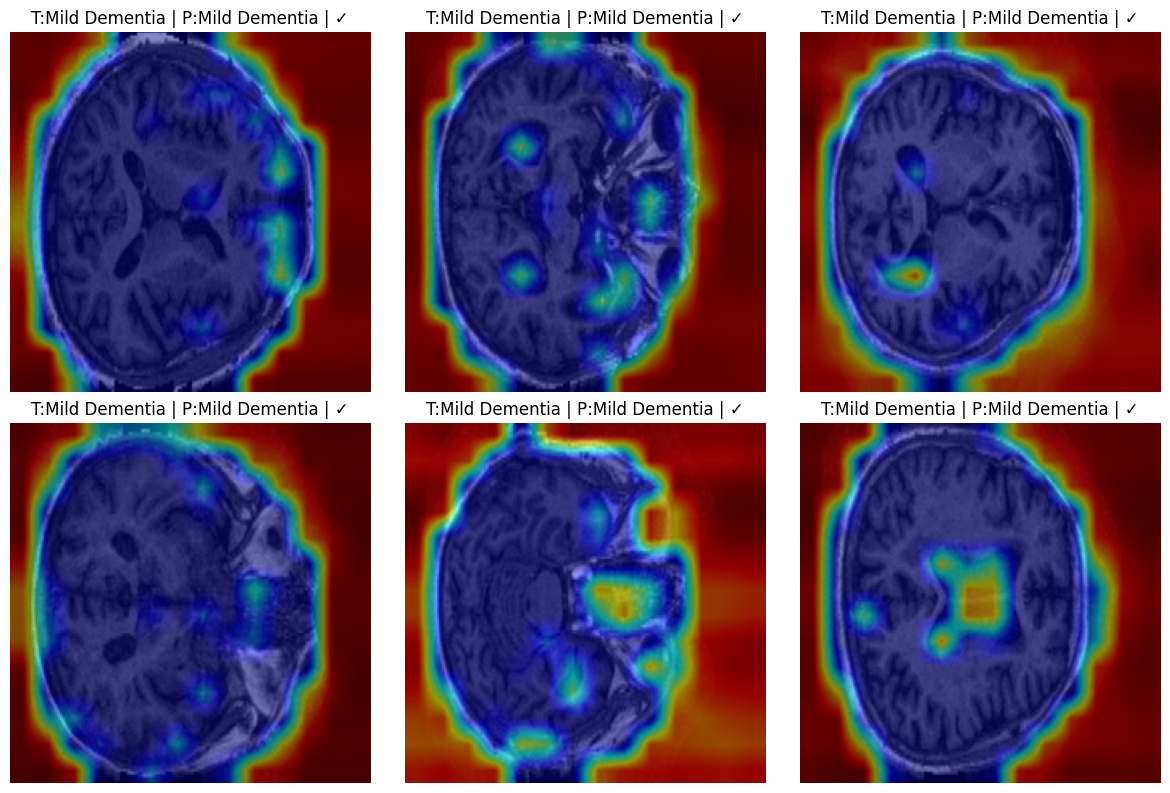

In [15]:
# After the CAM loop, display a few examples inline
import matplotlib.pyplot as plt

N_SHOW = 6   # how many to show inline
plt.figure(figsize=(12, 8))

for i, item in enumerate(manifest[:N_SHOW]):
    img = Image.open(item["cam_path"])
    plt.subplot(2, math.ceil(N_SHOW/2), i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"T:{item['true']} | P:{item['pred']} | {'✓' if item['correct'] else '✗'}")

plt.tight_layout()
plt.show()


Device: cuda
Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


Scanning test: 100%|██████████| 203/203 [01:59<00:00,  1.70it/s]


Selected 8 images (2 per class)


Grad-CAM selected: 100%|██████████| 8/8 [00:00<00:00, 17.65it/s]


Saved 8 overlays to: /kaggle/working/gradcam_out_selected


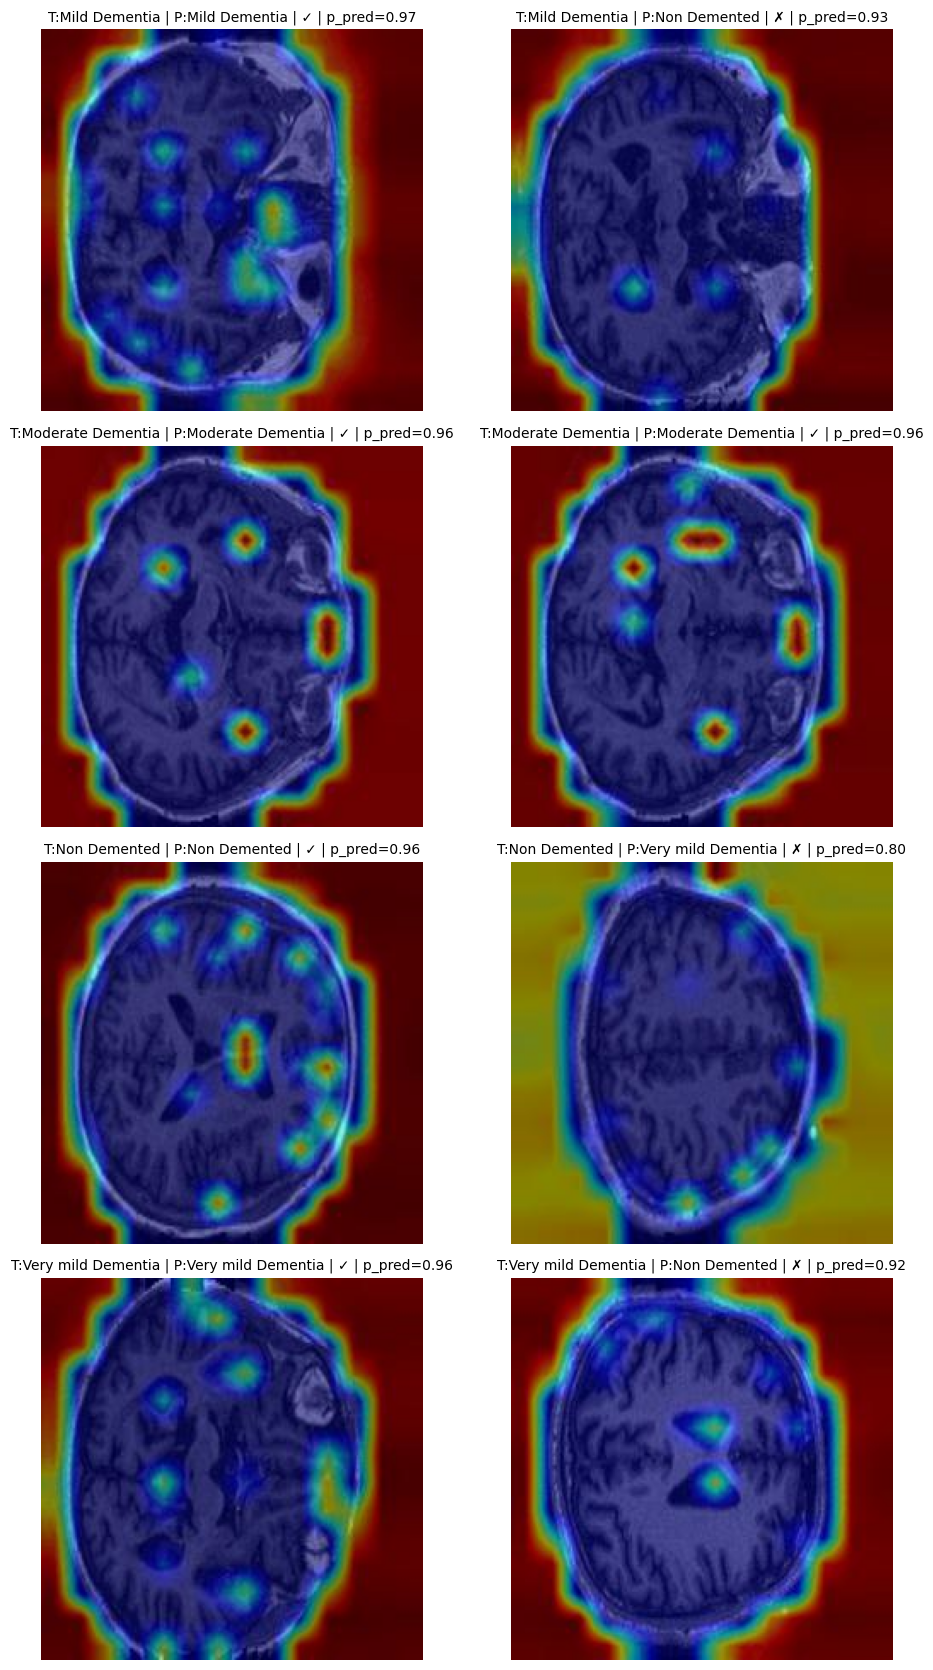

Saved collage: /kaggle/working/gradcam_out_selected/collage_2_per_class.png


In [16]:
# ==== Grad-CAM: 2 samples per class (prefer 1 correct + 1 incorrect) ====
!pip -q install grad-cam >/dev/null

import os, json, math, random, warnings
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model

import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

warnings.filterwarnings("ignore")

# ---------------- Config ----------------
MODEL_NAME = "vit_base_patch16_224"
IMG_SIZE   = 224
BATCH_SIZE = 64
SEED       = 42

SAMPLES_PER_CLASS = 2         # <-- exactly 2 per class
PREFER_SPLIT      = (1, 1)    # (correct, incorrect) target per class; fills from corrects if not enough mistakes

CKPT_PATH = "/kaggle/input/alzheimer-vit-checkpoints/best_by_f1.pt"
TEST_DIR  = "/kaggle/input/working-dataset/data_split/test"

OUT_DIR = "/kaggle/working/gradcam_out_selected"
os.makedirs(OUT_DIR, exist_ok=True)

IMAGENET_MEAN=[0.485,0.456,0.406]
IMAGENET_STD =[0.229,0.224,0.225]

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --------------- Data -------------------
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
test_ds = datasets.ImageFolder(TEST_DIR, transform=tfm)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
classes = test_ds.classes; C = len(classes)
print("Classes:", classes)

# --------------- Model ------------------
model = create_model(MODEL_NAME, pretrained=False, num_classes=C).to(device)
try:
    state = torch.load(CKPT_PATH, map_location=device, weights_only=True)
except TypeError:
    state = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state)
model.eval()

# --------------- Inference over test to pick examples ------------------
all_logits, all_preds, all_trues = [], [], []
with torch.no_grad():
    for imgs, lbls in tqdm(test_loader, desc="Scanning test"):
        imgs = imgs.to(device)
        logits = model(imgs)
        all_logits.append(logits.cpu())
        all_preds.extend(logits.argmax(1).cpu().tolist())
        all_trues.extend(lbls.tolist())
all_logits = torch.cat(all_logits, dim=0)
all_probs  = F.softmax(all_logits, dim=1).numpy()

# Group indices per class into correct/incorrect
per_class = {c: {"correct": [], "incorrect": []} for c in range(C)}
for idx, (y_true, y_pred) in enumerate(zip(all_trues, all_preds)):
    entry = {
        "idx": idx,
        "pred": y_pred,
        "true": y_true,
        "p_pred": float(all_probs[idx, y_pred]),
        "p_true": float(all_probs[idx, y_true]),
        "top2": np.argsort(-all_probs[idx])[:2].tolist(),
        "probs": all_probs[idx].tolist(),
    }
    if y_pred == y_true:
        per_class[y_true]["correct"].append(entry)
    else:
        per_class[y_true]["incorrect"].append(entry)

# Deterministic shuffle for variety
rng = random.Random(SEED)
for c in range(C):
    rng.shuffle(per_class[c]["correct"])
    rng.shuffle(per_class[c]["incorrect"])

# Select exactly 2 per class (prefer 1 correct + 1 incorrect; backfill with correct)
selected = []
want_correct, want_incorrect = PREFER_SPLIT
for c in range(C):
    picks = []
    picks += per_class[c]["correct"][:want_correct]
    picks += per_class[c]["incorrect"][:want_incorrect]
    if len(picks) < SAMPLES_PER_CLASS:
        # backfill from remaining corrects, then incorrects
        remain = [e for e in per_class[c]["correct"][want_correct:]] + \
                 [e for e in per_class[c]["incorrect"][want_incorrect:]]
        picks += remain[:(SAMPLES_PER_CLASS - len(picks))]
    selected.extend(picks[:SAMPLES_PER_CLASS])

print(f"Selected {len(selected)} images ({SAMPLES_PER_CLASS} per class)")

# --------------- Grad-CAM setup (ViT reshape) ------------------
def vit_reshape_transform(tensor):
    if isinstance(tensor, (list, tuple)):
        tensor = tensor[0]
    B, T, C = tensor.shape
    H = W = int((T - 1) ** 0.5)
    x = tensor[:, 1:, :].reshape(B, H, W, C).permute(0, 3, 1, 2).contiguous()
    return x

target_layers = [model.blocks[-1].norm1]
cam = GradCAMPlusPlus(model=model, target_layers=target_layers, reshape_transform=vit_reshape_transform)

def unnorm(img_t):
    x = img_t.clone().cpu().numpy()
    for ch in range(3):
        x[ch] = x[ch]*IMAGENET_STD[ch] + IMAGENET_MEAN[ch]
    return np.clip(x.transpose(1,2,0), 0, 1)

# Helper to load a single sample by index with same transform
def load_by_index(idx):
    path, true_lbl = test_ds.samples[idx]
    pil = Image.open(path).convert("L").resize((IMG_SIZE, IMG_SIZE))
    rgb = Image.merge("RGB", (pil, pil, pil))
    t = tfm(rgb)
    return path, true_lbl, t

# --------------- Generate CAMs for selected set ------------------
manifest = []
for e in tqdm(selected, desc="Grad-CAM selected"):
    idx = e["idx"]
    path, true_lbl, img_t = load_by_index(idx)
    inp = img_t.unsqueeze(0).to(device)

    # Use predicted class for CAM (change to true_lbl if you want)
    pred_lbl = e["pred"]
    targets = [ClassifierOutputTarget(pred_lbl)]
    cam_map = cam(input_tensor=inp, targets=targets, eigen_smooth=True)[0]

    overlay = show_cam_on_image(unnorm(img_t), cam_map, use_rgb=True)
    base = os.path.basename(path)
    name = f"c{true_lbl}_{classes[true_lbl]}__pred-{classes[pred_lbl]}__p{e['p_pred']:.2f}_{base}"
    out_path = os.path.join(OUT_DIR, name)
    Image.fromarray(overlay).save(out_path)

    manifest.append({
        "src": path,
        "cam": out_path,
        "true_idx": int(true_lbl),
        "true": classes[true_lbl],
        "pred_idx": int(pred_lbl),
        "pred": classes[pred_lbl],
        "correct": bool(true_lbl == pred_lbl),
        "p_pred": round(e["p_pred"], 4),
        "p_true": round(e["p_true"], 4),
        "top2": e["top2"],
        "probs": [round(float(p), 4) for p in e["probs"]],
    })

with open(os.path.join(OUT_DIR, "selected_gradcams.json"), "w") as f:
    json.dump({"classes": classes, "items": manifest}, f, indent=2)

print(f"Saved {len(manifest)} overlays to: {OUT_DIR}")

# --------------- Show inline grid: 2 per class ------------------
cols = 2
rows = len(classes) * (SAMPLES_PER_CLASS // cols)
rows = max(rows, 2)
plt.figure(figsize=(cols*5.2, rows*4.2))

# Order by class, keep 2 each
by_class = {c: [] for c in range(C)}
for item in manifest:
    by_class[item["true_idx"]].append(item)
for c in range(C):
    by_class[c] = by_class[c][:SAMPLES_PER_CLASS]

flat = []
for c in range(C):
    flat.extend(by_class[c])

for i, item in enumerate(flat):
    img = Image.open(item["cam"])
    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    title = (f"T:{item['true']} | P:{item['pred']} "
             f"| {'✓' if item['correct'] else '✗'} "
             f"| p_pred={item['p_pred']:.2f}")
    plt.title(title, fontsize=10)
    plt.axis("off")

plt.tight_layout()
collage_path = os.path.join(OUT_DIR, "collage_2_per_class.png")
plt.savefig(collage_path, dpi=180)
plt.show()
print("Saved collage:", collage_path)


In [20]:
# STEP 2: Inspect demographics CSV
import pandas as pd

DEMOG_CSV = "/kaggle/input/oasis-demographic-dataset/oasis_demographic.csv"  # <-- update

demog = pd.read_csv(DEMOG_CSV)
print("Shape:", demog.shape)
print("\nColumns:", list(demog.columns))

# Peek at first few rows
display(demog.head(5))

# Check missing values
print("\nMissing values per column:")
print(demog.isna().sum())

# Check datatypes
print("\nData types:")
print(demog.dtypes)

# Look for any column that might be subject IDs
candidate_id_cols = [c for c in demog.columns if "id" in c.lower() or "subject" in c.lower()]
print("\nPossible ID columns:", candidate_id_cols)


Shape: (436, 12)

Columns: ['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Delay']


ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743  1.306   
1  OAS1_0002_MR1   F    R   55   4.0  1.0  29.0  0.0  1147  0.810  1.531   
2  OAS1_0003_MR1   F    R   73   4.0  3.0  27.0  0.5  1454  0.708  1.207   
3  OAS1_0004_MR1   M    R   28   NaN  NaN   NaN  0.0  1588  0.803  1.105   
4  OAS1_0005_MR1   M    R   18   NaN  NaN   NaN  0.0  1737  0.848  1.010   

   Delay  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN


Missing values per column:
ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR        0
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64

Data types:
ID        object
M/F       object
Hand      object
Age        int64
Educ     float64
SES      float64
MMSE     float64
CDR      float64
eTIV       int64
nWBV     float64
ASF      float64
Delay    float64
dtype: object

Possible ID columns: ['ID']


In [21]:
# STEP 2b: Clean demographics
demog_clean = demog.copy()

# Rename columns
demog_clean = demog_clean.rename(columns={
    "ID": "subject_id",
    "M/F": "Sex",
    "Hand": "Handedness",
    "Educ": "Education",
    "SES": "SES",
    "MMSE": "MMSE",
    "CDR": "CDR",
    "eTIV": "eTIV",
    "nWBV": "nWBV",
    "ASF": "ASF",
    "Delay": "Delay"
})

# Normalize IDs (drop _MR1 suffix to match MRI file naming)
demog_clean["subject_id"] = demog_clean["subject_id"].str.replace("_MR1","", regex=False)

# Drop "Delay" (too sparse)
demog_clean = demog_clean.drop(columns=["Delay"])

# Check result
print("Cleaned demographics shape:", demog_clean.shape)
print("Columns:", list(demog_clean.columns))
display(demog_clean.head(5))

# Check missingness again
print("\nMissing values after cleaning:")
print(demog_clean.isna().sum())


Cleaned demographics shape: (436, 11)
Columns: ['subject_id', 'Sex', 'Handedness', 'Age', 'Education', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']


subject_id Sex Handedness  Age  Education  SES  MMSE  CDR  eTIV   nWBV  \
0  OAS1_0001   F          R   74        2.0  3.0  29.0  0.0  1344  0.743   
1  OAS1_0002   F          R   55        4.0  1.0  29.0  0.0  1147  0.810   
2  OAS1_0003   F          R   73        4.0  3.0  27.0  0.5  1454  0.708   
3  OAS1_0004   M          R   28        NaN  NaN   NaN  0.0  1588  0.803   
4  OAS1_0005   M          R   18        NaN  NaN   NaN  0.0  1737  0.848   

     ASF  
0  1.306  
1  1.531  
2  1.207  
3  1.105  
4  1.010


Missing values after cleaning:
subject_id      0
Sex             0
Handedness      0
Age             0
Education     201
SES           220
MMSE          201
CDR             0
eTIV            0
nWBV            0
ASF             0
dtype: int64


In [22]:
# STEP 3: Check ID overlap between features and demographics
import pandas as pd
import re

# Load extracted features (test split example)
features = pd.read_csv("/kaggle/input/working-dataset/extracted_features_test.csv")
print("Features shape:", features.shape)
display(features.head(3)[["filename","true","pred","p_pred"]])

# Parse subject ID from filenames (OAS1_0001_mpr.nii.gz -> OAS1_0001)
def parse_id(fname):
    m = re.search(r"(OAS1_\d+)", fname)
    return m.group(1) if m else None

features["subject_id"] = features["filename"].apply(parse_id)

# Check overlap with demographics
feat_ids = set(features["subject_id"].dropna())
demog_ids = set(demog_clean["subject_id"].dropna())

print("\nFeature IDs:", len(feat_ids))
print("Demographics IDs:", len(demog_ids))
print("Overlap:", len(feat_ids & demog_ids))

# Show a few IDs that didn't match
print("\nExample unmatched IDs in features:", list(feat_ids - demog_ids)[:10])
print("Example unmatched IDs in demographics:", list(demog_ids - feat_ids)[:10])


Features shape: (12968, 776)


filename           true           pred    p_pred
0  OAS1_0028_MR1_mpr-1_101.jpg  Mild Dementia  Mild Dementia  0.966125
1  OAS1_0028_MR1_mpr-1_107.jpg  Mild Dementia  Mild Dementia  0.962249
2  OAS1_0028_MR1_mpr-1_111.jpg  Mild Dementia  Mild Dementia  0.966556


Feature IDs: 347
Demographics IDs: 436
Overlap: 347

Example unmatched IDs in features: []
Example unmatched IDs in demographics: ['OAS1_0395', 'OAS1_0428', 'OAS1_0439', 'OAS1_0399', 'OAS1_0061_MR2', 'OAS1_0415', 'OAS1_0404', 'OAS1_0440', 'OAS1_0420', 'OAS1_0402']


In [23]:
# STEP 4: Merge features with demographics
# Add subject_id to features if not already
import pandas as pd
import re

features = pd.read_csv("/kaggle/input/working-dataset/extracted_features_test.csv")
features["subject_id"] = features["filename"].apply(lambda f: re.search(r"(OAS1_\d+)", f).group(1))

# Merge with demographics
merged = features.merge(demog_clean, on="subject_id", how="left")

print("Merged shape:", merged.shape)
print("Missing demographics after merge:", merged.isna().sum().sum())
display(merged.head(5)[["filename","true","pred","Age","Sex","Education","MMSE","CDR"]])

# Save
out_csv = "/kaggle/working/features_test_with_demog2.csv"
merged.to_csv(out_csv, index=False)
print("Saved:", out_csv)


Merged shape: (12968, 787)
Missing demographics after merge: 18074


filename           true           pred  Age Sex  \
0  OAS1_0028_MR1_mpr-1_101.jpg  Mild Dementia  Mild Dementia   86   F   
1  OAS1_0028_MR1_mpr-1_107.jpg  Mild Dementia  Mild Dementia   86   F   
2  OAS1_0028_MR1_mpr-1_111.jpg  Mild Dementia  Mild Dementia   86   F   
3  OAS1_0028_MR1_mpr-1_115.jpg  Mild Dementia  Mild Dementia   86   F   
4  OAS1_0028_MR1_mpr-1_117.jpg  Mild Dementia  Mild Dementia   86   F   

   Education  MMSE  CDR  
0        2.0  27.0  1.0  
1        2.0  27.0  1.0  
2        2.0  27.0  1.0  
3        2.0  27.0  1.0  
4        2.0  27.0  1.0

Saved: /kaggle/working/features_test_with_demog2.csv


In [24]:
# STEP 5: Sanity-check merged data
import pandas as pd

merged = pd.read_csv("/kaggle/working/features_test_with_demog2.csv")

print("Shape:", merged.shape)

# Unique subjects
n_subjects = merged["subject_id"].nunique()
print("Unique subjects:", n_subjects)

# Missing counts (demographics only)
demog_cols = ["Age","Sex","Education","SES","MMSE","CDR"]
print("\nMissing values per demographic column:")
print(merged[demog_cols].isna().sum())

# Distribution by sex
print("\nSex distribution (subjects):")
print(merged.groupby("Sex")["subject_id"].nunique())

# Distribution by age bins
merged["Age_bin"] = pd.cut(merged["Age"], bins=[0,40,60,80,100], labels=["<40","40-59","60-79","80+"])
print("\nAge bin distribution (subjects):")
print(merged.groupby("Age_bin")["subject_id"].nunique())

# Model accuracy overall vs by sex
merged["correct"] = (merged["true"] == merged["pred"])
overall_acc = merged["correct"].mean()
acc_by_sex = merged.groupby("Sex")["correct"].mean()

print("\nOverall Accuracy:", round(overall_acc,4))
print("Accuracy by Sex:\n", acc_by_sex)


Shape: (12968, 787)
Unique subjects: 347

Missing values per demographic column:
Age             0
Sex             0
Education    5809
SES          6456
MMSE         5809
CDR             0
dtype: int64

Sex distribution (subjects):
Sex
F    210
M    137
Name: subject_id, dtype: int64

Age bin distribution (subjects):
Age_bin
<40      127
40-59     56
60-79    110
80+       54
Name: subject_id, dtype: int64

Overall Accuracy: 0.9736
Accuracy by Sex:
 Sex
F    0.976061
M    0.969787
Name: correct, dtype: float64


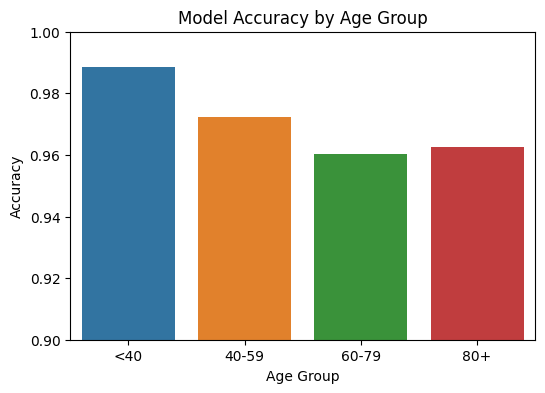

Accuracy by Age group:
 Age_bin
<40      0.989
40-59    0.972
60-79    0.960
80+      0.963
Name: correct, dtype: float64


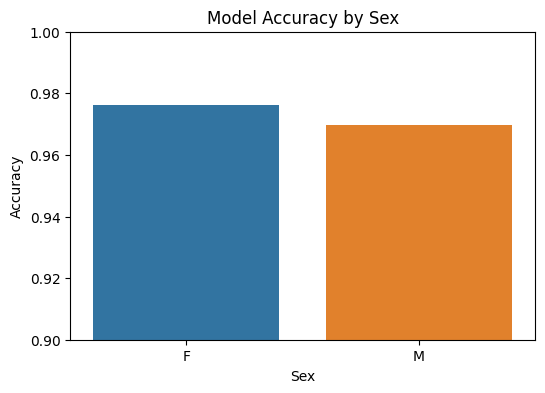


Accuracy by Sex:
 Sex
F    0.976
M    0.970
Name: correct, dtype: float64


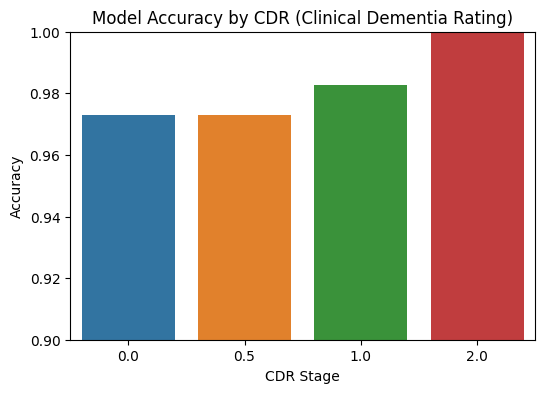


Accuracy by CDR stage:
 CDR
0.0    0.973
0.5    0.973
1.0    0.983
2.0    1.000
Name: correct, dtype: float64


In [25]:
# STEP 6: Subgroup analysis (Age, Sex, CDR)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

merged = pd.read_csv("/kaggle/working/features_test_with_demog2.csv")

# Mark correct predictions
merged["correct"] = (merged["true"] == merged["pred"])

# -------------------------------
# Accuracy by Age bin
# -------------------------------
merged["Age_bin"] = pd.cut(merged["Age"], bins=[0,40,60,80,100], labels=["<40","40-59","60-79","80+"])
acc_by_age = merged.groupby("Age_bin")["correct"].mean()

plt.figure(figsize=(6,4))
sns.barplot(x=acc_by_age.index, y=acc_by_age.values)
plt.title("Model Accuracy by Age Group")
plt.ylabel("Accuracy")
plt.xlabel("Age Group")
plt.ylim(0.9,1.0)
plt.show()

print("Accuracy by Age group:\n", acc_by_age.round(3))

# -------------------------------
# Accuracy by Sex
# -------------------------------
acc_by_sex = merged.groupby("Sex")["correct"].mean()

plt.figure(figsize=(6,4))
sns.barplot(x=acc_by_sex.index, y=acc_by_sex.values)
plt.title("Model Accuracy by Sex")
plt.ylabel("Accuracy")
plt.ylim(0.9,1.0)
plt.show()

print("\nAccuracy by Sex:\n", acc_by_sex.round(3))

# -------------------------------
# Accuracy by CDR (severity stage)
# -------------------------------
acc_by_cdr = merged.groupby("CDR")["correct"].mean()

plt.figure(figsize=(6,4))
sns.barplot(x=acc_by_cdr.index, y=acc_by_cdr.values)
plt.title("Model Accuracy by CDR (Clinical Dementia Rating)")
plt.ylabel("Accuracy")
plt.xlabel("CDR Stage")
plt.ylim(0.9,1.0)
plt.show()

print("\nAccuracy by CDR stage:\n", acc_by_cdr.round(3))



### Confusion matrices by Age_bin

Age_bin = <40  | n=5100


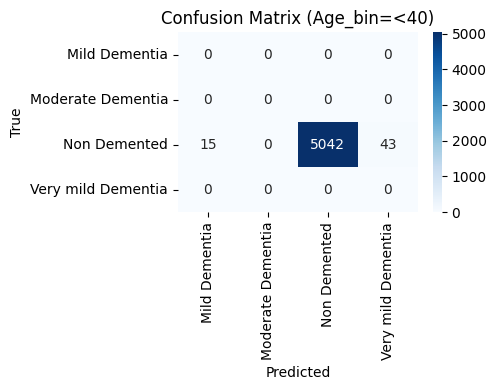


Age_bin = 40-59  | n=1952


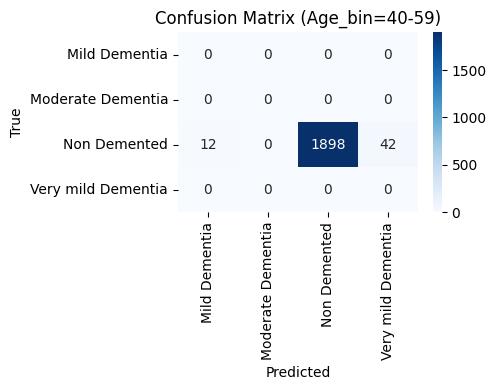


Age_bin = 60-79  | n=3908


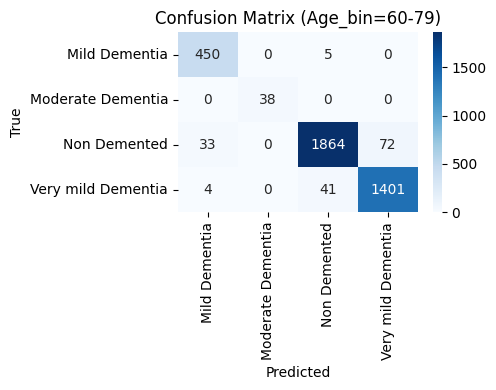


Age_bin = 80+  | n=2008


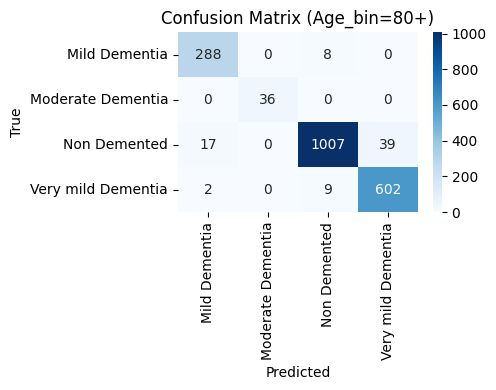


### Confusion matrices by Sex

Sex = F  | n=7937


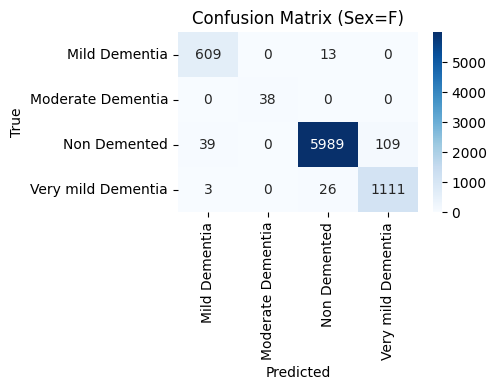


Sex = M  | n=5031


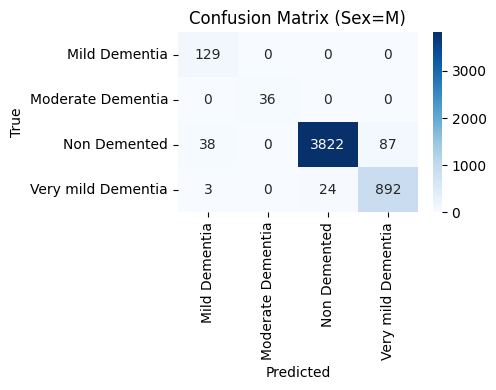


### Confusion matrices by CDR

CDR = 0.0  | n=10084


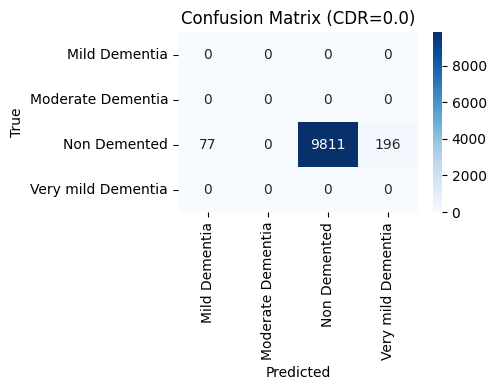


CDR = 0.5  | n=2059


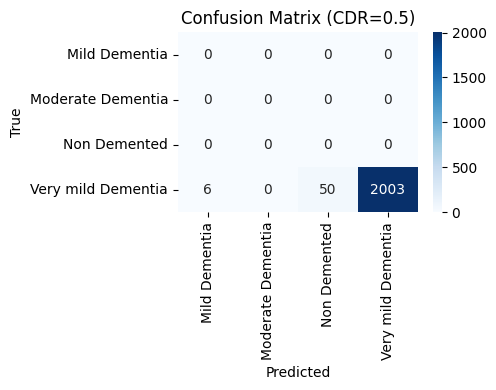


CDR = 1.0  | n=751


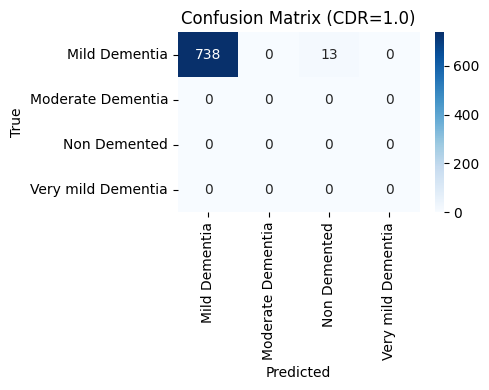


CDR = 2.0  | n=74


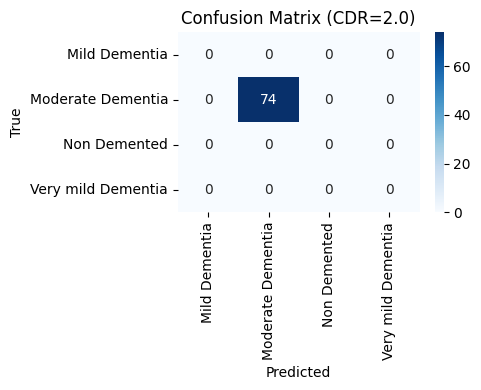

In [26]:
# STEP 7: Subgroup confusion matrices (Age, Sex, CDR)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

merged = pd.read_csv("/kaggle/working/features_test_with_demog2.csv")

# Define subgroup variables
merged["Age_bin"] = pd.cut(merged["Age"], bins=[0,40,60,80,100], labels=["<40","40-59","60-79","80+"])

# List of subgroups to evaluate
subgroups = {
    "Age_bin": merged["Age_bin"].unique().categories,  # categorical bins
    "Sex": merged["Sex"].unique(),
    "CDR": sorted(merged["CDR"].unique())
}

classes = merged["true"].unique()

def plot_confusion(cm, labels, title, fname=None):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=150)
    plt.show()

# Generate confusion matrices by subgroup
for subgroup, values in subgroups.items():
    print(f"\n### Confusion matrices by {subgroup}")
    for val in values:
        subset = merged[merged[subgroup] == val]
        if subset.empty: 
            continue
        cm = confusion_matrix(subset["true"], subset["pred"], labels=classes)
        print(f"\n{subgroup} = {val}  | n={len(subset)}")
        plot_confusion(cm, labels=classes, 
                       title=f"Confusion Matrix ({subgroup}={val})")


Found feature columns: 768
First few feature cols: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']
Feature matrix shape before NaN drop: (12968, 768)
Feature matrix shape after NaN drop: (12968, 768)
Downsampled to 5000 points for plotting.
PCA variance explained (2D): 0.8637


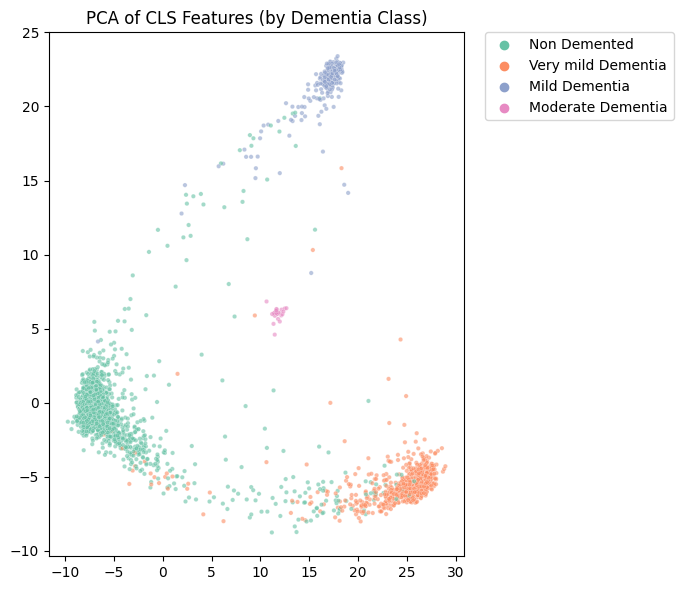

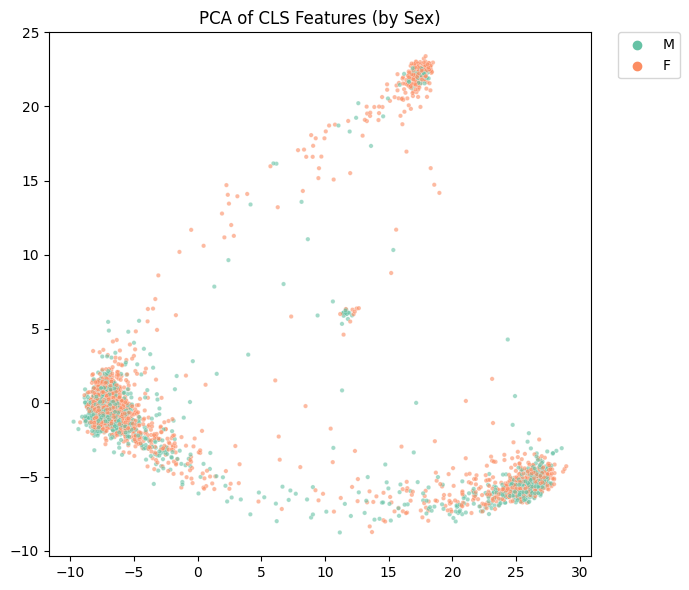

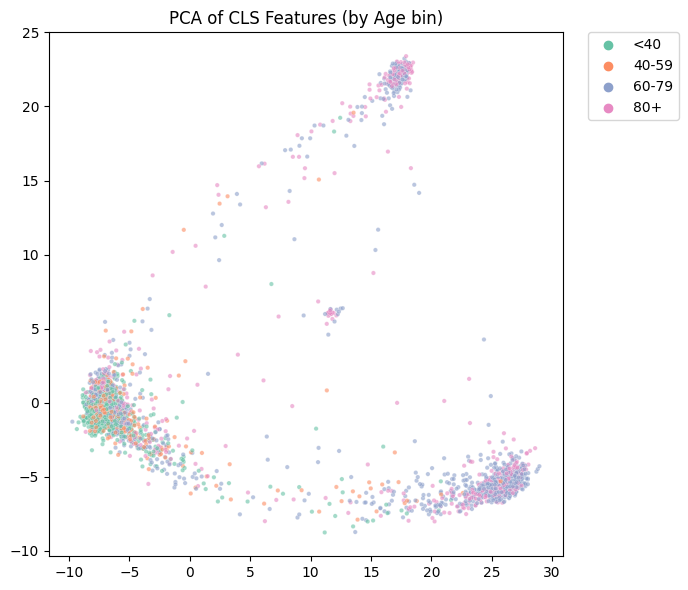

In [27]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load merged table
merged = pd.read_csv("/kaggle/working/features_test_with_demog2.csv")

# 1) Pick ONLY CLS feature columns named like f0, f1, ... f767 (strict regex)
feat_cols = [c for c in merged.columns if re.fullmatch(r"f\d+", c) is not None]
print("Found feature columns:", len(feat_cols))
print("First few feature cols:", feat_cols[:10])

# Safety: if none found, stop with a helpful message
if not feat_cols:
    raise ValueError("No feature columns found matching r'^f\\d+$'. "
                     "Check your features_* CSV to confirm columns are named f0..f767.")

# 2) Build numeric feature matrix X
X = merged[feat_cols].apply(pd.to_numeric, errors="coerce").values
print("Feature matrix shape before NaN drop:", X.shape)

# Optional: drop rows with any NaN in features (should be none, but safe)
row_mask = ~np.isnan(X).any(axis=1)
X = X[row_mask]
meta = merged.loc[row_mask].reset_index(drop=True)

print("Feature matrix shape after NaN drop:", X.shape)

# 3) Labels for coloring
y_class  = meta["true"]
y_sex    = meta["Sex"]
y_agebin = pd.cut(meta["Age"], bins=[0,40,60,80,100], labels=["<40","40-59","60-79","80+"])

# 4) (Optional) downsample for faster plotting
DOWNSAMPLE = 5000   # set to None to use all points
if DOWNSAMPLE and len(meta) > DOWNSAMPLE:
    sample_idx = np.random.default_rng(42).choice(len(meta), size=DOWNSAMPLE, replace=False)
    X = X[sample_idx]
    y_class  = y_class.iloc[sample_idx].reset_index(drop=True)
    y_sex    = y_sex.iloc[sample_idx].reset_index(drop=True)
    y_agebin = y_agebin.iloc[sample_idx].reset_index(drop=True)
    print(f"Downsampled to {len(sample_idx)} points for plotting.")

# 5) PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
print("PCA variance explained (2D):", round(pca.explained_variance_ratio_.sum(), 4))

def plot_scatter(X2d, labels, title):
    plt.figure(figsize=(7,6))
    sns.scatterplot(x=X2d[:,0], y=X2d[:,1], hue=labels, s=10, alpha=0.6, palette="Set2")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

plot_scatter(X_pca, y_class,  "PCA of CLS Features (by Dementia Class)")
plot_scatter(X_pca, y_sex,    "PCA of CLS Features (by Sex)")
plot_scatter(X_pca, y_agebin, "PCA of CLS Features (by Age bin)")


In [49]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE).eval()

# force model to run in float32 (so it matches your input)
model = model.float()


In [53]:
import torch, numpy as np, cv2
from PIL import Image
import torchvision.transforms as T
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.reshape_transforms import vit_reshape_transform

# 1. Load your ViT model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE).eval().float()

# 2. Target layer for ViT (last block norm1)
target_layer = model.blocks[-1].norm1

# 3. Preprocess image
img_path = "/kaggle/input/oasisdataset/Very mild Dementia/OAS1_0003_MR1_mpr-1_103.jpg"
transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
pil_img = Image.open(img_path).convert("RGB")
x = transform(pil_img).unsqueeze(0).to(DEVICE)

# 4. Predict
with torch.no_grad():
    out = model(x)
    probs = torch.softmax(out, dim=1)
    pred_idx = probs.argmax(1).item()
    conf = probs.max().item()
print(f"Prediction: {pred_idx} (confidence={conf:.2f})")

# 5. Grad-CAM (new API: no use_cuda)
cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=vit_reshape_transform)
grayscale_cam = cam(input_tensor=x, targets=[ClassifierOutputTarget(pred_idx)])[0]

# 6. Convert to numpy images
def to_numpy_img(t):
    mean = np.array([0.485,0.456,0.406]).reshape(3,1,1)
    std  = np.array([0.229,0.224,0.225]).reshape(3,1,1)
    img = (t.detach().cpu().numpy()*std + mean).clip(0,1)
    return np.moveaxis(img, 0, -1)

rgb_01 = to_numpy_img(x[0])
heatmap = show_cam_on_image(rgb_01, grayscale_cam, use_rgb=True)

# 7. Save side-by-side
orig = (rgb_01*255).astype(np.uint8)
panel = np.concatenate([orig, heatmap], axis=1)
cv2.imwrite("gradcam_vit_comparison.png", cv2.cvtColor(panel, cv2.COLOR_RGB2BGR))
print("Saved gradcam_vit_comparison.png")


Prediction: 3 (confidence=0.96)
Saved gradcam_vit_comparison.png


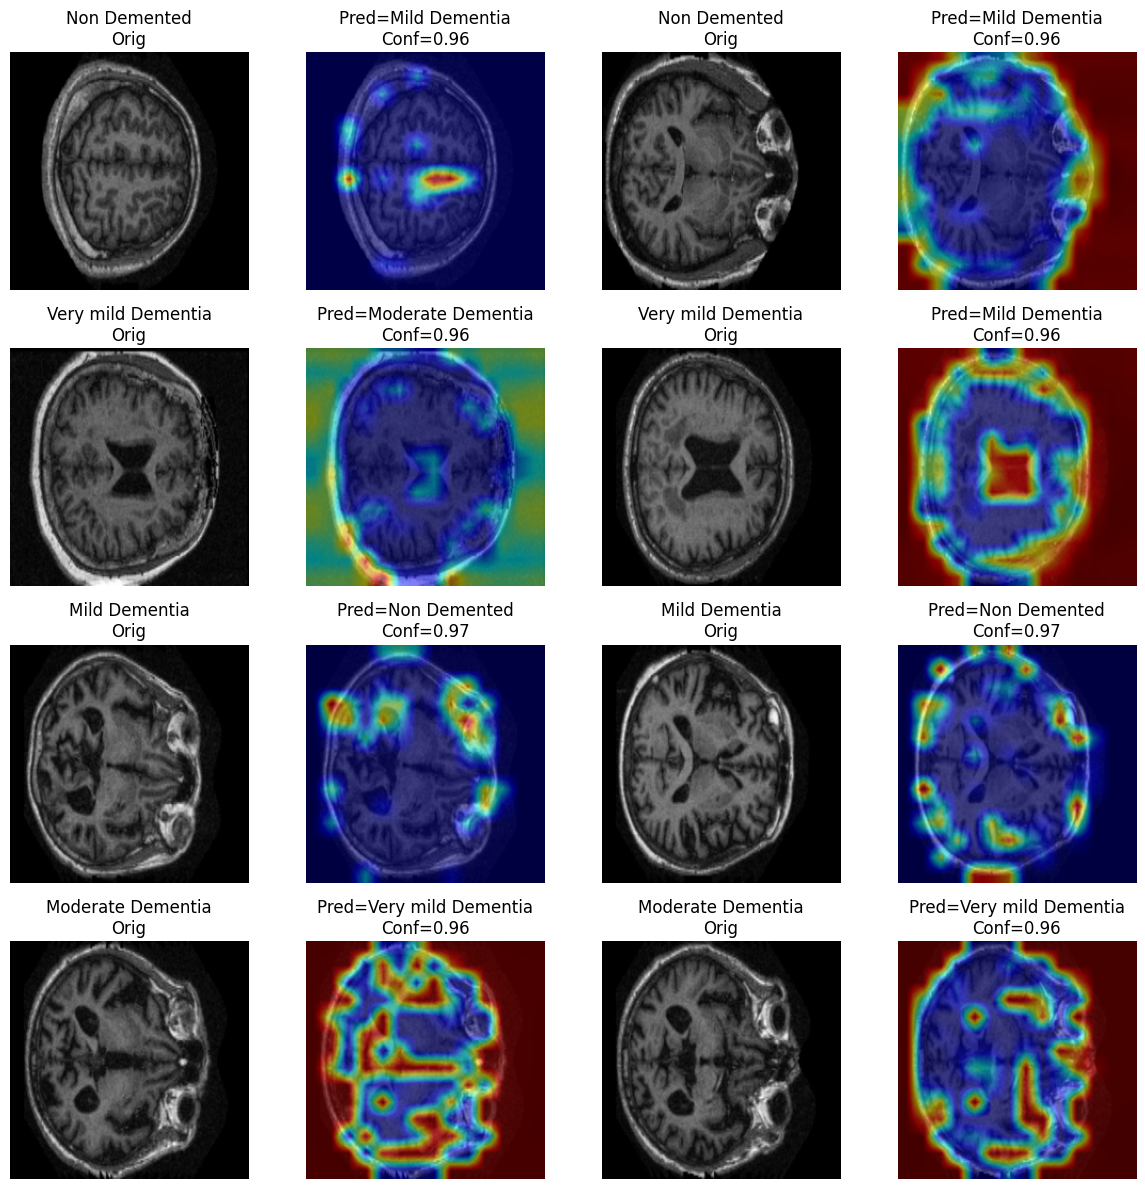

In [62]:
import os, torch, numpy as np, matplotlib.pyplot as plt, cv2
from PIL import Image
import torchvision.transforms as T
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.reshape_transforms import vit_reshape_transform

# ----------------------------
# 1. Config
# ----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE).eval().float()
target_layer = model.blocks[-1].norm1  # for ViT
classes = ["Non Demented", "Very mild Dementia", "Mild Dementia", "Moderate Dementia"]
img_size = 224

# path where your images are stored in subfolders per class:
# dataset/
#   NonDemented/
#   VeryMild/
#   Mild/
#   Moderate/
dataset_dir = "/kaggle/input/oasisdataset"

# ----------------------------
# 2. Transforms
# ----------------------------
transform = T.Compose([
    T.Resize((img_size,img_size)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

def to_numpy_img(t):
    mean = np.array([0.485,0.456,0.406]).reshape(3,1,1)
    std  = np.array([0.229,0.224,0.225]).reshape(3,1,1)
    img = (t.detach().cpu().numpy()*std + mean).clip(0,1)
    return np.moveaxis(img, 0, -1)

# ----------------------------
# 3. Setup Grad-CAM
# ----------------------------
cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=vit_reshape_transform)

# ----------------------------
# 4. Loop: pick 2 images per class
# ----------------------------
fig, axes = plt.subplots(len(classes), 4, figsize=(12, 3*len(classes)))

for row, cls in enumerate(classes):
    cls_dir = os.path.join(dataset_dir, cls)
    files = [os.path.join(cls_dir,f) for f in os.listdir(cls_dir) if f.lower().endswith((".png",".jpg",".jpeg"))]
    files = files[:2]  # pick first 2 for simplicity

    for col, fpath in enumerate(files):
        pil_img = Image.open(fpath).convert("RGB")
        x = transform(pil_img).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            out = model(x)
            probs = torch.softmax(out, dim=1)
            pred_idx = probs.argmax(1).item()
            conf = probs.max().item()

        grayscale_cam = cam(input_tensor=x, targets=[ClassifierOutputTarget(pred_idx)])[0]

        rgb_01 = to_numpy_img(x[0])
        heatmap = show_cam_on_image(rgb_01, grayscale_cam, use_rgb=True)

        # Plot Original
        axes[row, col*2].imshow(rgb_01)
        axes[row, col*2].set_title(f"{cls}\nOrig")
        axes[row, col*2].axis("off")

        # Plot Grad-CAM
        axes[row, col*2+1].imshow(heatmap)
        axes[row, col*2+1].set_title(f"Pred={classes[pred_idx]}\nConf={conf:.2f}")
        axes[row, col*2+1].axis("off")

plt.tight_layout()
plt.show()


In [66]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import textwrap, torch

# MODEL_ID = "mistralai/Mistral-7B-Instruct-v0.3"  # swap later to compare
MODEL_ID = "microsoft/Phi-3.5-mini-instruct"
tok = AutoTokenizer.from_pretrained(MODEL_ID)
mdl = AutoModelForCausalLM.from_pretrained(MODEL_ID, torch_dtype="auto", device_map="auto")

SYSTEM_PROMPT = ("You are a cautious radiology assistant. Write concise, professional MRI brain assessment notes "
                 "for Alzheimer’s spectrum classification. Use neutral phrasing like 'findings suggest'. "
                 "Include a short 'Limitations' section. Avoid treatment advice.")

def build_prompt(
    patient_id, age, sex, mmse, cdr,
    predicted_class, confidence,
    cam_note_text, cam_hot_frac, panel_path,
    pca_note=None
):
    user = f"""
Patient ID: {patient_id}
Age: {age}, Sex: {sex}
MMSE: {mmse}, CDR: {cdr}

Model Prediction: {predicted_class}
Confidence: {confidence:.2f}

Grad-CAM Summary:
- Qualitative: {cam_note_text}
- Quantitative: CAM>0.6 area fraction = {cam_hot_frac:.2f}
- Image reference: {panel_path}
{('CLS/PCA context: ' + pca_note) if pca_note else ''}

Task:
1) Write a Clinical-Style Diagnostic Note (~120–180 words) in radiology tone.
2) Add a one-sentence Impression.
3) Add a short Limitations section (AI model, single-slice context, Grad-CAM is not segmentation).
4) Do NOT state a definitive diagnosis or treatment plan.
""".strip()

    return f"<s>[SYSTEM]\n{SYSTEM_PROMPT}\n[/SYSTEM]\n[USER]\n{user}\n[/USER]\n[ASSISTANT]\n"

gen = pipeline(
    "text-generation", model=mdl, tokenizer=tok,
    temperature=0.2, top_p=0.95, max_new_tokens=380, do_sample=True
)

# === EXAMPLE SINGLE CALL (fill with your values) ===
prompt = build_prompt(
    patient_id="OAS1_0028",
    age=74, sex="Female",
    mmse=27, cdr=1.0,
    predicted_class="Mild Dementia", confidence=0.96,
    cam_note_text="Focal attention in medial temporal regions; no diffuse cortical emphasis.",
    cam_hot_frac=0.18,
    panel_path="outputs/OAS1_0028_orig_vs_cam.png",
    pca_note="PC1/2/3 = [-1.23, 0.44, 0.10]; near Mild centroid"
)

text = gen(prompt)[0]["generated_text"].split("[ASSISTANT]",1)[-1].strip()
print(text)


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

Device set to use cuda:0


Clinical Diagnostic Note:

Patient ID: OAS1_0028
Age: 74, Sex: Female

MRI Brain Assessment:
The MRI of the brain demonstrates atrophy consistent with Alzheimer's disease spectrum, particularly in the medial temporal lobes. The qualitative analysis using Grad-CAM highlights focal attention in these regions, with an area fraction of 0.18, suggesting a localized pattern of atrophy. The patient's cognitive assessment, including MMSE score of 27 and CDR of 1.0, aligns with these imaging findings, supporting a classification within the mild dementia spectrum.

Impression:
Findings suggest mild Alzheimer's disease spectrum involvement, primarily in the medial temporal lobes.

Limitations:
- The Grad-CAM analysis provides a qualitative, not quantitative, assessment of atrophy patterns.
- The model's confidence level is high (0.96), but it does not replace clinical judgment.
- The analysis is based on a single-slice context and does not account for volumetric or segmentation data.
- The Grad-C

In [68]:
pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [76]:
import os, torch, numpy as np, cv2, pandas as pd
from PIL import Image
import torchvision.transforms as T

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.reshape_transforms import vit_reshape_transform

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Your trained model (already loaded)
model = model.to(DEVICE).eval().float()
CLASSES = ["Non Demented", "Very mild Dementia", "Mild Dementia", "Moderate Dementia"]

transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

def process_single_patient(img_path, demo_row, out_dir="outputs"):
    """Takes MRI + demographics row → saves GradCAM images + builds dict for report."""
    os.makedirs(out_dir, exist_ok=True)

    patient_id = demo_row["ID"]  # make sure your CSV has an "ID" column like OAS1_0001_MR1
    sex = demo_row["M/F"]
    age = demo_row["Age"]
    mmse = demo_row["MMSE"]
    cdr = demo_row["CDR"]

    # --- Load image ---
    pil_img = Image.open(img_path).convert("RGB")
    x = transform(pil_img).unsqueeze(0).to(DEVICE)

    # --- Prediction ---
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
        pred_idx = probs.argmax(1).item()
        confidence = probs.max().item()
    pred_class = CLASSES[pred_idx]

    # --- Grad-CAM ---
    target_layer = model.blocks[-1].norm1  # for ViT
    cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=vit_reshape_transform)
    grayscale_cam = cam(input_tensor=x, targets=[ClassifierOutputTarget(pred_idx)])[0]
    grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max()-grayscale_cam.min()+1e-6)
    cam_hot_frac = float((grayscale_cam >= 0.6).mean())

    # Overlay + panel
    def to_numpy_img(t):
        mean = np.array([0.485,0.456,0.406]).reshape(3,1,1)
        std  = np.array([0.229,0.224,0.225]).reshape(3,1,1)
        img = (t.detach().cpu().numpy()*std + mean).clip(0,1)
        return np.moveaxis(img, 0, -1)
    rgb_01 = to_numpy_img(x[0].cpu())
    overlay = show_cam_on_image(rgb_01, grayscale_cam, use_rgb=True)

    base = os.path.splitext(os.path.basename(img_path))[0]
    orig_out  = os.path.join(out_dir, f"{base}_orig.png")
    cam_out   = os.path.join(out_dir, f"{base}_cam.png")
    panel_out = os.path.join(out_dir, f"{base}_panel.png")
    pil_img.save(orig_out)
    cv2.imwrite(cam_out, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
    panel = np.concatenate([(rgb_01*255).astype(np.uint8), overlay], axis=1)
    cv2.imwrite(panel_out, cv2.cvtColor(panel, cv2.COLOR_RGB2BGR))

    # --- CLS feature preview (first 3 dims only) ---
    with torch.no_grad():
        feats = model.forward_features(x)
        cls = feats[:,0,:].cpu().numpy()[0]
    pca_note = f"CLS preview dims: [{cls[0]:.2f}, {cls[1]:.2f}, {cls[2]:.2f}]"

    # --- Build report row ---
    row = {
        "patient_id": patient_id,
        "sex": sex,
        "age": age,
        "mmse": mmse,
        "cdr": cdr,
        "predicted_class": pred_class,
        "confidence": confidence,
        "cam_hot_frac": cam_hot_frac,
        "cam_note_text": f"Focal attention with CAM>0.6 fraction {cam_hot_frac:.2f}",
        "pca_note": pca_note,
        "orig_path": orig_out,
        "cam_path": cam_out,
        "panel_path": panel_out
    }
    return row


In [79]:
# Load your demographics CSV
demo = pd.read_csv("/kaggle/input/oasis-demographic-dataset/oasis_demographic.csv")

# Pick one patient row
row_demo = demo.loc[demo["ID"]=="OAS1_0003_MR1"].iloc[0]

# Run pipeline
res = process_single_patient(
    img_path="/kaggle/input/oasisdataset/Very mild Dementia/OAS1_0003_MR1_mpr-1_100.jpg",
    demo_row=row_demo
)

# Build a prompt string
def build_prompt(r):
    return f"""
Clinical Diagnostic Note:

Patient ID: {r['patient_id']}
Age: {r['age']}, Sex: {r['sex']}

MRI Brain Assessment:
Classified as {r['predicted_class']} (confidence={r['confidence']:.2f}).
Grad-CAM highlights focal attention; CAM>0.6 fraction = {r['cam_hot_frac']:.2f}.
{r['cam_note_text']}
MMSE={r['mmse']}, CDR={r['cdr']}
Features: {r['pca_note']}

Impression:
Findings suggest involvement consistent with {r['predicted_class']}.

Limitations:
- AI model prediction, not clinical diagnosis.
- Single-slice only, not volumetric.
- Grad-CAM highlights attention, not segmentation.
""".strip()

print(build_prompt(res))


Clinical Diagnostic Note:

Patient ID: OAS1_0003_MR1
Age: 73, Sex: F

MRI Brain Assessment:
Classified as Moderate Dementia (confidence=0.96).
Grad-CAM highlights focal attention; CAM>0.6 fraction = 0.70.
Focal attention with CAM>0.6 fraction 0.70
MMSE=27.0, CDR=0.5
Features: CLS preview dims: [-0.88, 0.07, -0.08]

Impression:
Findings suggest involvement consistent with Moderate Dementia.

Limitations:
- AI model prediction, not clinical diagnosis.
- Single-slice only, not volumetric.
- Grad-CAM highlights attention, not segmentation.


In [81]:
# pip install reportlab pillow pytorch-grad-cam torchvision

import os, re, math, torch, numpy as np, cv2
from PIL import Image
import torchvision.transforms as T
from datetime import datetime

from reportlab.lib.pagesizes import A4
from reportlab.lib.units import cm
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as RLImage, Table, TableStyle
from reportlab.lib import colors

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
# use vit reshape; for Swin see comment below
from pytorch_grad_cam.utils.reshape_transforms import vit_reshape_transform

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------------------
# CONFIG you may change
# ---------------------------
CLASSES = ["Non Demented", "Very mild Dementia", "Mild Dementia", "Moderate Dementia"]  # match your model
IMG_SIZE = 224  # match your training input size
HEAT_THRESH = 0.6

# Expect your already-loaded trained model here:
#   e.g., model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=4)
#         model.load_state_dict(torch.load("best.pth", map_location="cpu"))
#         model = model.to(DEVICE).eval().float()
# If you're using Swin or a CNN, see the "TARGET LAYER" section below.
# ---------------------------------------------------------
# model = <YOUR TRAINED MODEL OBJECT>
# ---------------------------------------------------------

# --------------- Utilities ---------------
transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

def to_numpy_img(t):
    mean = np.array([0.485,0.456,0.406]).reshape(3,1,1)
    std  = np.array([0.229,0.224,0.225]).reshape(3,1,1)
    img = (t.detach().cpu().numpy()*std + mean).clip(0,1)
    return np.moveaxis(img, 0, -1)

def ensure_dir(path):
    d = os.path.dirname(path)
    if d and not os.path.exists(d):
        os.makedirs(d, exist_ok=True)

# --------------- PDF builder (two images) ---------------
def build_two_image_pdf(out_pdf, *, header_rows, cam_note_text, orig_image_path, gradcam_image_path,
                        title="MRI Brain Assessment (AI-assisted)"):
    ensure_dir(out_pdf)
    doc = SimpleDocTemplate(out_pdf, pagesize=A4,
                            rightMargin=1.4*cm, leftMargin=1.4*cm,
                            topMargin=1.4*cm, bottomMargin=1.4*cm)
    styles = getSampleStyleSheet()
    styles.add(ParagraphStyle(name="Small", fontSize=9, textColor=colors.grey))
    styles.add(ParagraphStyle(name="H2", parent=styles["Heading2"], spaceBefore=10, spaceAfter=6))
    styles.add(ParagraphStyle(name="Body", parent=styles["BodyText"], leading=14))

    story = []
    story.append(Paragraph(title, styles["Title"]))
    story.append(Paragraph(datetime.now().strftime("%Y-%m-%d %H:%M"), styles["Small"]))
    story.append(Spacer(1, 6))

    tbl = Table(header_rows, colWidths=[4.3*cm, None])
    tbl.setStyle(TableStyle([
        ("GRID", (0,0), (-1,-1), 0.25, colors.lightgrey),
        ("BACKGROUND", (0,0), (-1,0), colors.whitesmoke),
        ("VALIGN", (0,0), (-1,-1), "MIDDLE"),
        ("FONTNAME", (0,0), (-1,-1), "Helvetica"),
        ("FONTSIZE", (0,0), (-1,-1), 9),
    ]))
    story.append(tbl)
    story.append(Spacer(1, 10))

    story.append(Paragraph("Explainability (Grad-CAM):", styles["H2"]))
    story.append(Paragraph(cam_note_text, styles["Body"]))
    story.append(Spacer(1, 6))
    story.append(Paragraph("Original (left) vs Grad-CAM (right)", styles["Small"]))

    max_w_each_cm = (A4[0]/cm - 2.8) / 2
    img1 = RLImage(orig_image_path, width=max_w_each_cm*cm, height=None)
    img2 = RLImage(gradcam_image_path, width=max_w_each_cm*cm, height=None)
    grid = Table([[img1, img2]], colWidths=[max_w_each_cm*cm, max_w_each_cm*cm])
    grid.setStyle(TableStyle([("VALIGN", (0,0), (-1,-1), "MIDDLE")]))
    story.append(grid)

    story.append(Spacer(1, 10))
    story.append(Paragraph(
        "Note: Grad-CAM highlights model attention supporting the predicted class; it is not a segmentation mask. "
        "Interpret alongside clinical context.", styles["Small"])
    )

    doc.build(story)
    return out_pdf

# --------------- Core: process image & make PDF ---------------
def image_to_pdf(
    *,
    image_path: str,
    patient_id: str,
    age, sex, mmse, cdr,
    out_pdf: str = "reports/report.pdf",
    out_dir_images: str = "outputs",
    backbone: str = "vit"  # "vit" | "swin" | "cnn"
):
    """Load MRI → predict → Grad-CAM → save two images → generate PDF. Only needs your image path + patient fields."""
    assert 'model' in globals(), "Please load your trained model into a variable named `model`."
    ensure_dir(out_pdf)
    os.makedirs(out_dir_images, exist_ok=True)

    # Load+prep
    pil_img = Image.open(image_path).convert("RGB")
    x = transform(pil_img).unsqueeze(0).to(DEVICE)

    # Prediction
    mdl = model.to(DEVICE).eval().float()
    with torch.no_grad():
        logits = mdl(x)
        probs = torch.softmax(logits, dim=1)
        pred_idx = probs.argmax(1).item()
        confidence = probs.max().item()
    pred_class = CLASSES[pred_idx]

    # TARGET LAYER:
    # ViT (timm): last block norm1 + vit_reshape_transform
    # Swin: use last stage block norm1 + swin reshape (requires import); or fallback norm layer
    # CNN (e.g., resnet): layer4[-1], reshape_transform=None
    if backbone == "vit":
        target_layer = mdl.blocks[-1].norm1
        reshape_tf = vit_reshape_transform
    elif backbone == "cnn":
        target_layer = mdl.layer4[-1]
        reshape_tf = None
    else:
        # basic Swin fallback without external import; often still works with vit_reshape_transform off
        # If you use Swin, ideally: from pytorch_grad_cam.utils.reshape_transforms import swin_reshape_transform
        target_layer = mdl.layers[-1].blocks[-1].norm1
        reshape_tf = None

    # Grad-CAM
    cam = GradCAM(model=mdl, target_layers=[target_layer], reshape_transform=reshape_tf)
    grayscale_cam = cam(input_tensor=x, targets=[ClassifierOutputTarget(pred_idx)])[0]
    grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-6)
    cam_hot_frac = float((grayscale_cam >= HEAT_THRESH).mean())

    # Make overlay & save images (we create paths for you)
    base = os.path.splitext(os.path.basename(image_path))[0]
    orig_out  = os.path.join(out_dir_images, f"{patient_id}_orig.png")
    cam_out   = os.path.join(out_dir_images, f"{patient_id}_cam.png")

    rgb_01 = to_numpy_img(x[0].cpu())
    overlay = show_cam_on_image(rgb_01, grayscale_cam, use_rgb=True)

    pil_img.save(orig_out)
    cv2.imwrite(cam_out, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    # Small explanatory sentence (you can replace)
    cam_note_text = (
        f"Model attention highlighted by Grad-CAM; CAM>{HEAT_THRESH:.2f} fraction = {cam_hot_frac:.2f}. "
        "Hotter regions indicate areas most influential for the predicted class."
    )

    # Build header rows (for the small table)
    header_rows = [
        ["Patient Number", str(patient_id)],
        ["Age / Sex", f"{age} / {sex}"],
        ["MMSE / CDR", f"{mmse} / {cdr}"],
        ["Prediction", f"{pred_class}"],
        ["Confidence", f"{confidence:.2f}"],
        ["CAM>0.6 fraction", f"{cam_hot_frac:.2f}"],
    ]

    pdf_path = build_two_image_pdf(
        out_pdf=out_pdf,
        header_rows=header_rows,
        cam_note_text=cam_note_text,
        orig_image_path=orig_out,
        gradcam_image_path=cam_out
    )
    return {
        "pdf_path": pdf_path,
        "orig_image": orig_out,
        "cam_image": cam_out,
        "predicted_class": pred_class,
        "confidence": confidence,
        "cam_hot_frac": cam_hot_frac
    }


In [85]:
# 1) Make sure your trained model is loaded into `model` (see config comment above)

# 2) Call the pipeline with ONE image + patient fields
result = image_to_pdf(
    image_path="/kaggle/input/oasisdataset/Very mild Dementia/OAS1_0003_MR1_mpr-1_100.jpg",
    patient_id="OAS1_0003_MR1",
    age=73, sex="F",
    mmse=27.0, cdr=0.5,
    out_pdf="/kaggle/working/reports/OAS1_0003_MR1_report.pdf",
    out_dir_images="outputs",
    backbone="vit"  # change to "cnn" or "swin" if needed
)

print("Saved PDF:", result["pdf_path"])
print("Original image saved at:", result["orig_image"])
print("Grad-CAM image saved at:", result["cam_image"])
print("Prediction:", result["predicted_class"], "Confidence:", f"{result['confidence']:.2f}")
print("CAM>0.6 fraction:", f"{result['cam_hot_frac']:.2f}")


Saved PDF: /kaggle/working/reports/OAS1_0003_MR1_report.pdf
Original image saved at: outputs/OAS1_0003_MR1_orig.png
Grad-CAM image saved at: outputs/OAS1_0003_MR1_cam.png
Prediction: Moderate Dementia Confidence: 0.96
CAM>0.6 fraction: 0.70


In [92]:
import os
from datetime import datetime
from PIL import Image
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import cm
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, Image as RLImage,
    Table, TableStyle, ListFlowable, ListItem
)

def build_affordable_style_pdf(
    *,
    out_pdf: str,
    # patient meta
    patient_id: str,
    age, sex, mmse, cdr,
    predicted_class: str,
    confidence: float,
    cam_hot_frac: float,
    # images
    hero_image_path: str,          # big image at top (often your Grad-CAM)
    orig_image_path: str,          # left image in comparison row
    gradcam_image_path: str,       # right image in comparison row
    # narrative (feel free to pass your own strings)
    history_text: str | None = None,
    procedure_bullets: list[str] | None = None,
    findings_text: str | None = None,
    impression_text: str | None = None,
    footer_note: str = "Grad-CAM highlights model attention; not a segmentation mask. Interpret with clinical context.",
    page_title: str = "MRI OF THE BRAIN",
    site_title: str = "MRI Brain Assessment (AI-assisted)",
):
    """
    Produces a report styled like the sample: big image at top + HISTORY/PROCEDURE/FINDINGS/IMPRESSION sections,
    then a comparison row (Original | Grad-CAM).
    """

    os.makedirs(os.path.dirname(out_pdf) or ".", exist_ok=True)

    # ---------- styles ----------
    styles = getSampleStyleSheet()
    styles.add(ParagraphStyle(name="H0", fontSize=22, leading=26, alignment=1, spaceAfter=8, spaceBefore=4))      # centered bold title
    styles.add(ParagraphStyle(name="Subtle", fontSize=9, textColor=colors.grey))
    styles.add(ParagraphStyle(name="H1", parent=styles["Heading1"], fontSize=14, spaceBefore=12, spaceAfter=6))
    styles.add(ParagraphStyle(name="Body", parent=styles["BodyText"], leading=14))
    styles.add(ParagraphStyle(name="Small", fontSize=9, textColor=colors.grey, leading=11))

    # ---------- doc ----------
    doc = SimpleDocTemplate(
        out_pdf, pagesize=A4,
        rightMargin=1.6*cm, leftMargin=1.6*cm, topMargin=1.6*cm, bottomMargin=1.6*cm
    )
    story = []

    # Site/title header row
    story.append(Paragraph(site_title, styles["H0"]))
    story.append(Paragraph(datetime.now().strftime("%Y-%m-%d %H:%M"), styles["Subtle"]))
    story.append(Spacer(1, 6))

    # Compact patient info table (right column like sample)
    info = [
        ["Patient Number", str(patient_id)],
        ["Age / Sex", f"{age} / {sex}"],
        ["MMSE / CDR", f"{mmse} / {cdr}"],
        ["Prediction", predicted_class],
        ["Confidence", f"{confidence:.2f}"],
        ["CAM>0.6 fraction", f"{cam_hot_frac:.2f}"],
    ]
    t = Table(info, colWidths=[4.2*cm, None])
    t.setStyle(TableStyle([
        ("BOX", (0,0), (-1,-1), 0.7, colors.lightgrey),
        ("GRID", (0,0), (-1,-1), 0.25, colors.lightgrey),
        ("BACKGROUND", (0,0), (-1,0), colors.whitesmoke),
        ("VALIGN", (0,0), (-1,-1), "MIDDLE"),
        ("FONTNAME", (0,0), (-1,-1), "Helvetica"),
        ("FONTSIZE", (0,0), (-1,-1), 9),
        ("ALIGN", (0,0), (0,-1), "LEFT"),
    ]))
    story.append(t)
    story.append(Spacer(1, 10))

    # Big centered image at top (hero)
    if os.path.exists(hero_image_path):
        max_w = A4[0]/cm - 3.2   # fit within margins
        hero = RLImage(hero_image_path, width=max_w*cm, height=None)
        story.append(hero)
        story.append(Spacer(1, 8))

    # Section: page title like the sample "MRI OF THE BRAIN"
    story.append(Paragraph(page_title, styles["H1"]))

    # HISTORY
    story.append(Paragraph("<b>HISTORY</b>", styles["Body"]))
    hist = history_text or (
        "AI-assisted assessment for cognitive concerns. Provided MMSE/CDR contextualize cognitive status. "
        "This report summarizes single-slice inference with attention visualization."
    )
    story.append(Paragraph(hist, styles["Body"]))
    story.append(Spacer(1, 6))

    # PROCEDURE
    story.append(Paragraph("<b>PROCEDURE</b>", styles["Body"]))
    bullets = procedure_bullets or [
        "Standard preprocessing and resizing to analysis resolution.",
        "Classification performed using a trained ViT model.",
        "Explainability generated via Grad-CAM on the last encoder block.",
    ]
    story.append(ListFlowable(
        [ListItem(Paragraph(s, styles["Body"]), leftIndent=12) for s in bullets],
        bulletType="1", start="1"
    ))
    story.append(Spacer(1, 6))

    # FINDINGS
    story.append(Paragraph("<b>FINDINGS</b>", styles["Body"]))
    find_txt = findings_text or (
        f"The AI classifier output is <b>{predicted_class}</b> with confidence {confidence:.2f}. "
        f"Grad-CAM highlights focal regions contributing to this decision "
        f"(CAM>0.60 fraction = {cam_hot_frac:.2f})."
    )
    story.append(Paragraph(find_txt, styles["Body"]))
    story.append(Spacer(1, 6))

    # IMPRESSION
    story.append(Paragraph("<b>IMPRESSION</b>", styles["Body"]))
    impr = impression_text or (
        f"Findings suggest a pattern consistent with the {predicted_class} spectrum, "
        "to be interpreted alongside clinical and imaging context."
    )
    story.append(Paragraph(impr, styles["Body"]))
    story.append(Spacer(1, 10))

    # Subsection label like your sample’s second block caption
    story.append(Paragraph("<b>Original vs Grad-CAM (comparison)</b>", styles["Body"]))
    story.append(Paragraph("Original (left), Grad-CAM (right)", styles["Small"]))
    story.append(Spacer(1, 4))

    # Two images side by side
    if os.path.exists(orig_image_path) and os.path.exists(gradcam_image_path):
        max_w_each = (A4[0]/cm - 3.2) / 2
        img1 = RLImage(orig_image_path, width=max_w_each*cm, height=None)
        img2 = RLImage(gradcam_image_path, width=max_w_each*cm, height=None)
        grid = Table([[img1, img2]], colWidths=[max_w_each*cm, max_w_each*cm])
        grid.setStyle(TableStyle([("VALIGN", (0,0), (-1,-1), "MIDDLE")]))
        story.append(grid)
        story.append(Spacer(1, 10))

    # Footer note
    story.append(Paragraph(footer_note, styles["Small"]))

    doc.build(story)
    return out_pdf


In [93]:
def one_path_to_pdf(
    *,
    image_path: str,
    patient_id: str,
    age, sex, mmse, cdr,
    out_pdf: str = "/kaggle/working/report.pdf",
    out_dir_images: str = "/kaggle/working/outputs",
    backbone: str = "vit"
):
    """
    1 path in (MRI), produces:
      - original PNG,
      - Grad-CAM overlay PNG,
      - PDF styled like radiology report with both images.
    """
    os.makedirs(out_dir_images, exist_ok=True)

    # --- run your existing image_to_pdf pipeline ---
    result = image_to_pdf(
        image_path=image_path,
        patient_id=patient_id,
        age=age, sex=sex,
        mmse=mmse, cdr=cdr,
        out_pdf=out_pdf,
        out_dir_images=out_dir_images,
        backbone=backbone
    )

    # --- reuse affordable-style template builder ---
    pdf_path = build_affordable_style_pdf(
        out_pdf=out_pdf,
        patient_id=patient_id,
        age=age, sex=sex, mmse=mmse, cdr=cdr,
        predicted_class=result["predicted_class"],
        confidence=result["confidence"],
        cam_hot_frac=result["cam_hot_frac"],
        hero_image_path=result["cam_image"],      # use Grad-CAM as hero
        orig_image_path=result["orig_image"],     # comparison left
        gradcam_image_path=result["cam_image"],   # comparison right
        # auto-fill text sections
        history_text=f"AI-assisted evaluation; MMSE={mmse}, CDR={cdr}.",
        findings_text=(
            f"Classifier output: <b>{result['predicted_class']}</b> "
            f"(confidence={result['confidence']:.2f}). "
            f"Grad-CAM highlights focal attention "
            f"(CAM>0.60 fraction={result['cam_hot_frac']:.2f})."
        ),
        impression_text=(
            f"Findings suggest involvement consistent with {result['predicted_class']} spectrum. "
            "Interpret with clinical correlation."
        )
    )
    return pdf_path


In [94]:
pdf_path = one_path_to_pdf(
    image_path="/kaggle/input/oasisdataset/Very mild Dementia/OAS1_0003_MR1_mpr-1_100.jpg",
    patient_id="OAS1_0003_MR1",
    age=73, sex="F",
    mmse=27.0, cdr=0.5,
    out_pdf="/kaggle/working/reports/OAS1_0003_MR1_report.pdf",
    out_dir_images="/kaggle/working/outputs",
    backbone="vit"
)

print("Saved PDF:", pdf_path)

from IPython.display import FileLink, HTML, display
display(FileLink(pdf_path))
display(HTML(f'<a href="{pdf_path}" download> Download Report PDF</a>'))


Saved PDF: /kaggle/working/reports/OAS1_0003_MR1_report.pdf


/kaggle/working/reports/OAS1_0003_MR1_report.pdf